# ``Taming Performance Variability''

### <font color='red'> Notebooks for experimentation with kernel two-sample testing in one and multiple dimensions.</font>

###  Sources:
- Paper: http://www.jmlr.org/papers/volume13/gretton12a/gretton12a.pdf
- Working example: http://www.shogun-toolbox.org/notebook/latest/mmd_two_sample_testing.html
- Shogun installation: http://shogun.ml/install

### Prerequisites:
- This notebook needs the latest version of the Shogun library (released after Feb 4th, 2018).

In [1]:
import os, sys
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
#import seaborn.apionly as sns
import seaborn as sns
import matplotlib.dates as md
from matplotlib import gridspec
import matplotlib.patches as patches
import datetime as dt
from collections import OrderedDict 
from collections import deque
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
import warnings
from scipy.stats import norm
from IPython.display import IFrame
from IPython.display import Markdown, display
from IPython.display import FileLink, FileLinks
import calendar
import shogun as sg
from scipy.stats import mannwhitneyu
from scipy.stats import entropy

# warnings.filterwarnings(action='once')

# plot_show_and_save() defined in bench_lib/common.py makes this magic unnecessary 
# (all plots should use plot_show_and_save())
#%matplotlib inline

# Improve plot quality for retina displays
%config InlineBackend.figure_format = 'retina'

# Read all inputs from this directory
source_dir = "../data/raw-data/"
# Save all dataframes and plots into this directory 
dest_dir = "output/"

if not os.path.isdir(dest_dir):
    os.mkdir(dest_dir)

# db -- dictinary with keys - table names, values - dataframes with table data
db = {}

for f in os.listdir(source_dir):
    if ".csv" in f:
        db[os.path.splitext(f)[0]] = pd.read_csv(source_dir + f)
    
# Allows setting values in dataframe copies without warnings (default='warn')
pd.options.mode.chained_assignment = None 

# If vebose is set, additional debug info will be printed. Use this flag throughout the notebook
verbose = True

if verbose:
    print "Keys: ", db.keys()
    for k, df in db.iteritems():
        #print "Sample from %s:" % k 
        #print df.head(3), "\n\n" 
        print "Columns in %s:" % k, df.columns.tolist(), "\n"

# Include common helper functions. You can see the avilable files and their code 
# if you use JupyterHub's file browser to navigate to the specifed directory 
sys.path.append("bench-lib/")
from common import *

# The warning showing up in the output comes from statsmodels, not our code 

/opt/conda/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Keys:  ['disk_info', 'iperf3_info', 'iperf3_results', 'ping_results', 'env_info', 'membench_info', 'disk_results', 'fio_info', 'stream_info', 'network_info', 'mem_results', 'ping_info']
Columns in disk_info: ['run_uuid', 'timestamp', 'nodeid', 'nodeuuid', 'disk_name', 'disk_model', 'disk_serial', 'disk_size', 'npartitions', 'disk_type'] 

Columns in iperf3_info: ['run_uuid', 'timestamp', 'nodeid', 'nodeuuid', 'version', 'local_ip', 'local_port', 'remote_ip', 'remote_port', 'remote_nodeid', 'protocol', 'num_streams', 'buffer_size', 'omitted_intervals', 'duration', 'time_units'] 

Columns in iperf3_results: ['run_uuid', 'timestamp', 'nodeid', 'nodeuuid', 'reverse', 'retransmits', 'local_cpu_util', 'remote_cpu_util', 'median', 'max', 'min', 'mean', 'stdev', 'sum_sent', 'sum_received', 'units'] 

Columns in ping_results: ['run_uuid', 'timestamp', 'nodeid', 'nodeuuid', 'runtime', 'packets_sent', 'packets_received', 'packet_loss', 'max', 'min', 'mean', 'stdev', 'ipg', 'ewma', 'units'] 

Colu

In [2]:
# Now, all datasets are values in the db dictionary (keys correspond to dataset names used in the actual database).

# Print high-level info 

print "The earliest disk perf sample: ", dt.datetime.fromtimestamp(db['disk_results']['timestamp'].min())
print "The latest disk perf sample: ", dt.datetime.fromtimestamp(db['disk_results']['timestamp'].max())

print "The earliest memory perf sample: ", dt.datetime.fromtimestamp(db['mem_results']['timestamp'].min())
print "The latest memory perf sample: ", dt.datetime.fromtimestamp(db['mem_results']['timestamp'].max())

print "Total number of samples: ", len(db['disk_results'])

# Use following line to print a sample from the disk dataset and transpose the dataframe for convenient viewing 
db['disk_results'].sample(20).T 

The earliest disk perf sample:  2017-05-20 09:18:32
The latest disk perf sample:  2018-04-04 18:12:08
The earliest memory perf sample:  2017-05-20 09:18:32
The latest memory perf sample:  2018-04-04 18:12:08
Total number of samples:  141408


117846  \
run_uuid   c3f06b47-98dc-4431-a51d-806d3b18e305   
timestamp                            1518505902   
nodeid                                   ms0415   
nodeuuid   6b82dc6b-72db-11e4-85c8-179a28bd1b8c   
testname                                   read   
runtime                                 138.988   
size                                1.04858e+07   
max                                       76840   
min                                       71520   
mean                                    75449.8   
stdev                                   605.872   
units                                      KB/s   
device                                /dev/sda2   
iodepth                                       1   

                                         109557  \
run_uuid   75f9adf1-5fc9-4e5b-9c80-b2980fe08827   
timestamp                            1516721790   
nodeid                            c220g2-011128   
nodeuuid   50affc6c-e8d4-11e5-a488-a3bb994732a6   
testname                              randwrite   
runtime                                 720.001   
size                                 1.7565e+06   
max                                        3128   
min                                        1432   
mean                                    2441.78   
stdev                                   190.298   
units                                      KB/s   
device                                /dev/sda4   
iodepth                                       1   

                                         66149   \
run_uuid   6f983a48-e93e-4354-bf0b-b5655ee03568   
timestamp                            1506364053   
nodeid                            c220g2-011024   
nodeuuid   1c2af438-e8ec-11e5-a488-a3bb994732a6   
testname                                  write   
runtime                                 114.285   
size                                1.04858e+07   
max                                      100752   
min                                       87776   
mean                                    91746.5   
stdev                                   1983.16   
units                                      KB/s   
device                                 /dev/sdb   
iodepth                                       1   

                                         66013   \
run_uuid   f2671a43-f158-4625-ae33-761805068b44   
timestamp                            1506342528   
nodeid                            c220g1-031122   
nodeuuid   693d70a3-3e70-11e6-b435-eb3e622294a9   
testname                              randwrite   
runtime                                 720.005   
size                                     641076   
max                                        1013   
min                                         508   
mean                                    890.986   
stdev                                    46.629   
units                                      KB/s   
device                                /dev/sda4   
iodepth                                       1   

                                         100162  \
run_uuid   22fbab53-68ad-4c9a-9a9f-9a41315567b4   
timestamp                            1515050232   
nodeid                                   ms1042   
nodeuuid   51b92e71-8ffa-11e6-8c08-a53a3a50acf8   
testname                                  write   
runtime                                  57.417   
size                                1.04858e+07   
max                                      227304   
min                                      121960   
mean                                     182723   
stdev                                   13642.3   
units                                      KB/s   
device                           /dev/nvme0n1p4   
iodepth                                       1   

                                         27653   \
run_uuid   bfeb9223-22bb-4d33-ae4f-bc39b5c2cef6   
timestamp                            1499214530   
nodeid                            c220g2-011323   
nodeuui

In [3]:
raw_disk_all, disk_all = process_disk(db)
raw_mem_all, mem_all = process_memory(db)
raw_net_all, net_all = process_network(db)

In [4]:
# Various breakdowns(column values and their corresponsing counts) can be obtained as follows

for c in ["units", "arch", "hw_type", "mem_clock_speed", "disk_type", "disk_model", "site", "testname"]:
    print dict(disk_all[c].value_counts()) 

{'KB/s': 138040}
{'aarch64': 28528, 'x86_64': 109512}
{'m510': 16048, 'c8220': 27872, 'm400': 28528, 'c220g2': 35504, 'c220g1': 18232, 'c6320': 11856}
{'1866MHz': 18232, 'UnknownMHz': 24, 'Unknown(ARM)': 28528, '1333MHz': 27872, '2400MHz': 16024, '2133MHz': 47360}
{'SSD': 62536, 'HDD': 75504}
{'XR0120GEBLT': 28528, 'HUC101212CSS600': 23664, 'INTEL SSDSC2BB48': 17960, 'ST1200MM0007': 12112, 'ST91000640NS': 39728, 'THNSN5256GPU7 TOSHIBA': 16048}
{'wisc': 53736, 'utah': 44576, 'clemson': 39728}
{'read': 34510, 'randread': 34510, 'write': 34510, 'randwrite': 34510}


In [5]:
# A few examples for memory
for c in ["units", "arch", "testname", "run_success", "nthreads", "nsockets", "mem_clock_speed", "dvfs", "socket_num"]:
    print dict(mem_all[c].value_counts())

{'MB/s': 741034}
{'aarch64': 49994, 'x86_64': 691040}
{'read_memory_avx_omp': 21595, 'write_memory_sse': 21595, 'triad_omp': 25166, 'write_memory_nontemporal_sse': 21595, 'add_omp': 25166, 'write_memory_rep_stosq_omp': 21595, 'write_memory_nontemporal_avx_omp': 21595, 'read_memory_sse_omp': 21595, 'scale': 25166, 'scale_omp': 25166, 'write_memory_loop_omp': 25166, 'read_memory_rep_lodsq': 21595, 'write_memory_memset': 25166, 'read_memory_loop_omp': 25166, 'copy_omp': 25166, 'read_memory_sse': 21595, 'read_memory_avx': 21595, 'read_memory_prefetch_avx': 21595, 'write_memory_avx_omp': 21595, 'read_memory_prefetch_avx_omp': 21595, 'add': 25166, 'write_memory_nontemporal_avx': 21595, 'write_memory_rep_stosq': 21595, 'read_memory_loop': 25166, 'copy': 25166, 'write_memory_sse_omp': 21595, 'read_memory_rep_lodsq_omp': 21595, 'write_memory_memset_omp': 25166, 'write_memory_avx': 21595, 'triad': 25166, 'write_memory_nontemporal_sse_omp': 21595, 'write_memory_loop': 25166}
{1: 721086, 2: 19948}

In [6]:
for hw_type, hw_grp in disk_all.groupby(["hw_type"]):
    print "Devices for %s:" % hw_type 
    print hw_grp["device"].value_counts()
    
print "\nSelected devices, one per hw_type:"
hw2device = {"c220g1": "/dev/sdc",
             "c220g2": "/dev/sdc",
             "c6320": "/dev/sdb",
             "c8220": "/dev/sdb",
             "m400": "/dev/sda2",
             "m510": "/dev/nvme0n1p4"}
print hw2device

Devices for c220g1:
/dev/sdc     6120
/dev/sdb     6104
/dev/sda4    6008
Name: device, dtype: int64
Devices for c220g2:
/dev/sdc     11840
/dev/sdb     11832
/dev/sda4    11832
Name: device, dtype: int64
Devices for c6320:
/dev/sdb     5928
/dev/sda4    5928
Name: device, dtype: int64
Devices for c8220:
/dev/sdb     13936
/dev/sda4    13936
Name: device, dtype: int64
Devices for m400:
/dev/sda2    28528
Name: device, dtype: int64
Devices for m510:
/dev/nvme0n1p4    16048
Name: device, dtype: int64

Selected devices, one per hw_type:
{'m510': '/dev/nvme0n1p4', 'c8220': '/dev/sdb', 'm400': '/dev/sda2', 'c220g2': '/dev/sdc', 'c220g1': '/dev/sdc', 'c6320': '/dev/sdb'}


In [7]:
# Define functions needed for kernel testing

def scale_median(data_p, data_q):
    # Scale: divide by median of the combined sample (which includes both data from p and q)    
    x_med = np.median(np.concatenate([data_p[0], data_q[0]]))
    y_med = np.median(np.concatenate([data_p[1], data_q[1]]))
    
    data_p_scaled = sg.RealFeatures(np.vstack( (list(np.array(data_p[0]) / x_med), 
                                                list(np.array(data_p[1]) / y_med) ))) 
    
    data_q_scaled = sg.RealFeatures(np.vstack( (list(np.array(data_q[0]) / x_med), 
                                                list(np.array(data_q[1]) / y_med) ))) 
    
    return data_p_scaled, data_q_scaled

def mmd_quadratic_no_heuristic(data_p, data_q, kw_list, alpha=0.05, null_samples=200):
    """ Run multiple quadratic time MMD tests with different kernel widths"""
    
    results = []
    for kw in kw_list:

        mmd = sg.QuadraticTimeMMD(data_p, data_q)
        mmd.set_kernel(sg.GaussianKernel(10, kw))

        # compute biased and unbiased test statistic (default is unbiased)
        #mmd.set_statistic_type(sg.ST_UNBIASED_FULL)
        mmd.set_statistic_type(sg.ST_BIASED_FULL)
        statistic = mmd.compute_statistic()
        
        mmd.set_null_approximation_method(sg.NAM_PERMUTATION)
        mmd.set_num_null_samples(null_samples)
        
        p_value=mmd.compute_p_value(statistic)

        # compute threshold for rejecting H_0 for a given test power
        threshold=mmd.compute_threshold(alpha)

        # compute the full two-sample test directly
        test_result = mmd.perform_test(alpha)
        distributions = "Different" if test_result else "Same" 
        
        results.append({"mmd_type": "quadratic",
                        "kernel_width": kw, 
                        "statistic": statistic,
                        "threshold": threshold,
                        "p_value": p_value, 
                        "alpha": alpha,
                        "test_result": test_result,
                        "distributions": distributions})
    return results

def mmd_quadratic_statistic_only(data_p, data_q, kw_list):
    """ Run multiple quadratic time MMD tests with different kernel widths"""
    
    results = []
    for kw in kw_list:

        mmd = sg.QuadraticTimeMMD(data_p, data_q)
        mmd.set_kernel(sg.GaussianKernel(10, kw))

        # compute biased and unbiased test statistic (default is unbiased)
        #mmd.set_statistic_type(sg.ST_UNBIASED_FULL)
        mmd.set_statistic_type(sg.ST_BIASED_FULL)
        statistic = mmd.compute_statistic()
        
        results.append({"mmd_type": "quadratic",
                        "kernel_width": kw, 
                        "statistic": statistic})
    return results

print "Done"

Done


kernel_width   mmd_type  statistic
0          0.10  quadratic   0.006514
1          0.25  quadratic   0.004218
2          0.50  quadratic   0.002787

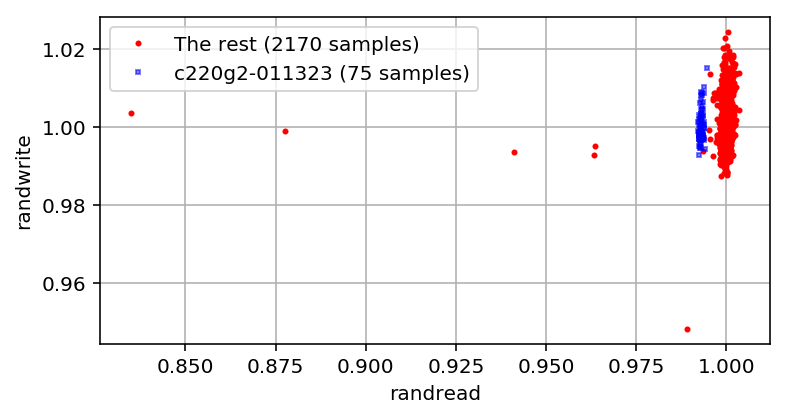

kernel_width   mmd_type  statistic
0          0.10  quadratic   0.536050
1          0.25  quadratic   0.229216
2          0.50  quadratic   0.117312

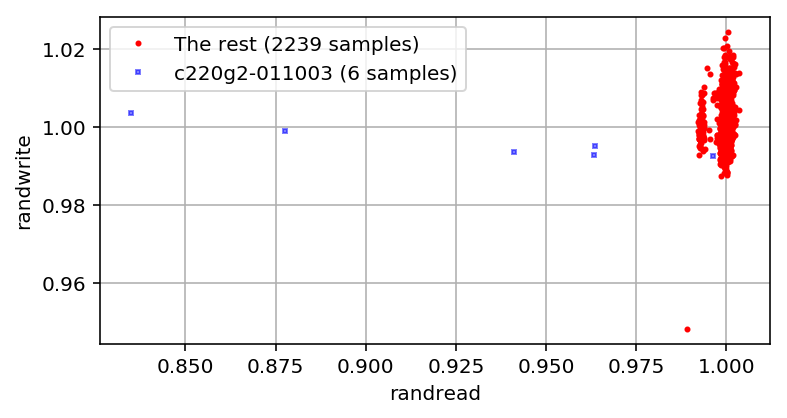

kernel_width   mmd_type  statistic
0          0.10  quadratic   0.002296
1          0.25  quadratic   0.005287
2          0.50  quadratic   0.002666

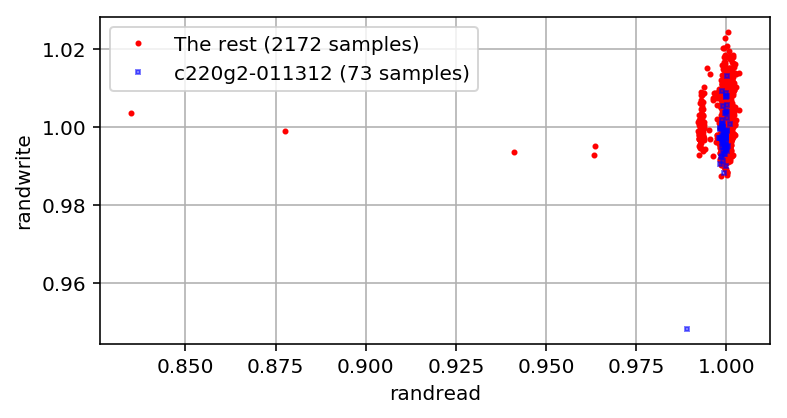

In [8]:
def compare_individual_and_combined(df_all, nodes, device, iodepth, 
                x_dim="randread", y_dim="randwrite", metric = "mean", alpha=0.05, train_test_ratio=1,
                kw_list=[0.5, 0.25, 0.1, 0.05, 0.025]):
    data = []

    x_combined = subset_df(df_all, {"device": device, "testname": x_dim, "iodepth": iodepth})    
    y_combined = subset_df(df_all, {"device": device, "testname": y_dim, "iodepth": iodepth})

    for n in nodes:  
        x_data = subset_df(df_all, {"nodeid": n, "device": device, "testname": x_dim, "iodepth": iodepth})
        y_data = subset_df(df_all, {"nodeid": n, "device": device, "testname": y_dim, "iodepth": iodepth}) 
        data.append([x_data[metric].tolist(), y_data[metric].tolist()])
        
    for idx2, n2 in enumerate(nodes):
        
        n1_data = [x_combined[x_combined["nodeid"] != n2][metric].tolist(), 
                   y_combined[y_combined["nodeid"] != n2][metric].tolist()]
    
        n2_data = data[idx2]

        # scaling
        n1_data_scaled, n2_data_scaled = scale_median(n1_data, n2_data) 
        n1_data = n1_data_scaled
        n2_data = n2_data_scaled

        fig, ax1 = plt.subplots(figsize=(6,3))

        ax1.plot(n1_data[0], n1_data[1], 'ro', markersize=2, label='$x$')
        ax1.plot(n2_data[0], n2_data[1], 'bs', markersize=2, label='$x$', alpha=0.5)

        # Plot styling
        ax1.legend(["%s (%d samples)" % ("The rest", len(n1_data[0])), "%s (%d samples)" % (n2, len(n2_data[0]))],)
        ax1.grid(True)
        ax1.set_xlabel(x_dim)
        ax1.set_ylabel(y_dim)

#         results = mmd_quadratic_no_heuristic(sg.RealFeatures(np.vstack((n1_data[0], n1_data[1]))), 
#                                     sg.RealFeatures(np.vstack((n2_data[0], n2_data[1]))),
#                                             kw_list=kw_list)
        results = mmd_quadratic_statistic_only(sg.RealFeatures(np.vstack((n1_data[0], n1_data[1]))), 
                                    sg.RealFeatures(np.vstack((n2_data[0], n2_data[1]))),
                                            kw_list=kw_list)

        display(pd.DataFrame(results))

        plot_show_and_save(fig, show_only=True)

hw_type = "c220g2"
iodepth = 4096
count_min = 50

### Get all nodes with >=count_min samples
# nodes = []
# for n, n_grp in subset_df(disk_all, 
#                           {"hw_type": hw_type, "device": hw2device[hw_type], 
#                            "testname": "randread", "iodepth": iodepth}).groupby("nodeid"):  
#     if len(n_grp) >= count_min:
#         nodes.append(n)

# Instead of all nodes, use a specific list
nodes = ["c220g2-011323", "c220g2-011003", "c220g2-011312"]
        
#compare_individual_and_combined(disk_all, nodes, hw2device[hw_type], iodepth, kw_list=[0.1, 0.25, 0.5])
compare_individual_and_combined(disk_all, nodes, "/dev/sdc", iodepth, kw_list=[0.1, 0.25, 0.5])

In [9]:
def inspect_and_exclude(df_all, nodes, device, iodepth, 
                x_dim="randread", y_dim="randwrite", metric = "mean", alpha=0.05, train_test_ratio=1,
                kw_list=[0.5, 0.25, 0.1, 0.05, 0.025]):
    data = []

    x_combined = subset_df(df_all, {"device": device, "testname": x_dim, "iodepth": iodepth})    
    y_combined = subset_df(df_all, {"device": device, "testname": y_dim, "iodepth": iodepth})

    for n in nodes:  
        x_data = subset_df(df_all, {"nodeid": n, "device": device, "testname": x_dim, "iodepth": iodepth})
        y_data = subset_df(df_all, {"nodeid": n, "device": device, "testname": y_dim, "iodepth": iodepth}) 
        data.append([x_data[metric].tolist(), y_data[metric].tolist()])
        
    res = pd.DataFrame()
    for idx2, n2 in enumerate(nodes):

        n1_data = [x_combined[x_combined["nodeid"] != n2][metric].tolist(), 
                   y_combined[y_combined["nodeid"] != n2][metric].tolist()]
    
        n2_data = data[idx2]

        # scaling
        n1_data_scaled, n2_data_scaled = scale_median(n1_data, n2_data) 
        n1_data = n1_data_scaled
        n2_data = n2_data_scaled

        results = mmd_quadratic_statistic_only(sg.RealFeatures(np.vstack((n1_data[0], n1_data[1]))), 
                                    sg.RealFeatures(np.vstack((n2_data[0], n2_data[1]))),
                                            kw_list=kw_list)
        results = pd.DataFrame(results)
        results["node"] = n2

        res = pd.concat([res, results])
        
    return res

hw_type = "c220g2"
iodepth = 4096
count_min = 10

print "Total number of nodes:", len(disk_all["nodeid"].unique())

nodes = []
for n, n_grp in subset_df(disk_all, 
                          {"hw_type": hw_type, "device": hw2device[hw_type], 
                           "testname": "randread", "iodepth": iodepth}).groupby("nodeid"):  
    if len(n_grp) >= count_min:
        nodes.append(n)
        
disk_all_selected = disk_all[disk_all["nodeid"].isin(nodes)]
print "Total number of nodes in the selected subset (with count threshold):", len(disk_all_selected["nodeid"].unique())
print "Total number of measurements in this subset:", len(disk_all_selected)

print "Starting loop"
iteration=0
metrics = []
while True:

    print "Iteration:", iteration
    
    res = inspect_and_exclude(disk_all_selected, nodes, hw2device[hw_type], iodepth, kw_list=[0.05, 0.1, 0.25, 0.5])

    aggregated = res.groupby(['node']).aggregate(np.mean).sort_values(["statistic"])
    aggregated["id"] = range(len(aggregated)) 
    #display(aggregated)

    excluded_node = aggregated["statistic"].idxmax()
    print "Excluding:", excluded_node
    
    iteration += 1
    
    aggregated
    
    disk_all_selected = disk_all_selected[disk_all_selected["nodeid"] != excluded_node]
    nodes.remove(excluded_node) 
    
    metrics.append({"Iteration": iteration, "Excluded": excluded_node, 
                    "MMD Excluded": aggregated["statistic"].max(),
                    "MMD Average": aggregated.drop([excluded_node])["statistic"].mean()})
    
    if len(nodes) == 1:
        break
        
metrics = pd.DataFrame(metrics)
display(metrics)

Total number of nodes: 835
Total number of nodes in the selected subset (with count threshold): 31
Total number of measurements in this subset: 24072
Starting loop
Iteration: 0
Excluding: c220g2-011323
Iteration: 1
Excluding: c220g2-011308
Iteration: 2
Excluding: c220g2-011324
Iteration: 3
Excluding: c220g2-011318
Iteration: 4
Excluding: c220g2-011312
Iteration: 5
Excluding: c220g2-011322
Iteration: 6
Excluding: c220g2-010823
Iteration: 7
Excluding: c220g2-011327
Iteration: 8
Excluding: c220g2-011311
Iteration: 9
Excluding: c220g2-011315
Iteration: 10
Excluding: c220g2-011108
Iteration: 11
Excluding: c220g2-011002
Iteration: 12
Excluding: c220g2-011306
Iteration: 13
Excluding: c220g2-011023
Iteration: 14
Excluding: c220g2-011021
Iteration: 15
Excluding: c220g2-011022
Iteration: 16
Excluding: c220g2-011330
Iteration: 17
Excluding: c220g2-011011
Iteration: 18
Excluding: c220g2-011124
Iteration: 19
Excluding: c220g2-011310
Iteration: 20
Excluding: c220g2-011332
Iteration: 21
Excluding: c2

Excluded  Iteration  MMD Average  MMD Excluded
0   c220g2-011323          1     0.009114      0.046264
1   c220g2-011308          2     0.007662      0.017357
2   c220g2-011324          3     0.007379      0.013959
3   c220g2-011318          4     0.007051      0.012642
4   c220g2-011312          5     0.007093      0.014019
5   c220g2-011322          6     0.006610      0.012348
6   c220g2-010823          7     0.006285      0.010642
7   c220g2-011327          8     0.005999      0.009848
8   c220g2-011311          9     0.005661      0.008743
9   c220g2-011315         10     0.005016      0.008633
10  c220g2-011108         11     0.004571      0.006469
11  c220g2-011002         12     0.004147      0.005663
12  c220g2-011306         13     0.003824      0.005212
13  c220g2-011023         14     0.003553      0.004859
14  c220g2-011021         15     0.003299      0.004386
15  c220g2-011022         16     0.003018      0.003714
16  c220g2-011330         17     0.002417      0.003014
17  c220g2-011011         18     0.002104      0.002727
18  c220g2-011124         19     0.001880      0.002735
19  c220g2-011310         20     0.001517      0.002583
20  c220g2-011332         21     0.001222      0.001398
21  c220g2-011005         22     0.001090      0.001249
22  c220g2-011316         23     0.000814      0.000925
23  c220g2-011328         24     0.000532      0.000619
24  c220g2-011024         25     0.000385      0.000458
25  c220g2-011309         26     0.000210      0.000278
26  c220g2-011126         27     0.000094      0.000170
27  c220g2-011008         28     0.000045      0.000067
28  c220g2-030631         29     0.000019      0.000028
29  c220g2-011110         30     0.000024      0.000026

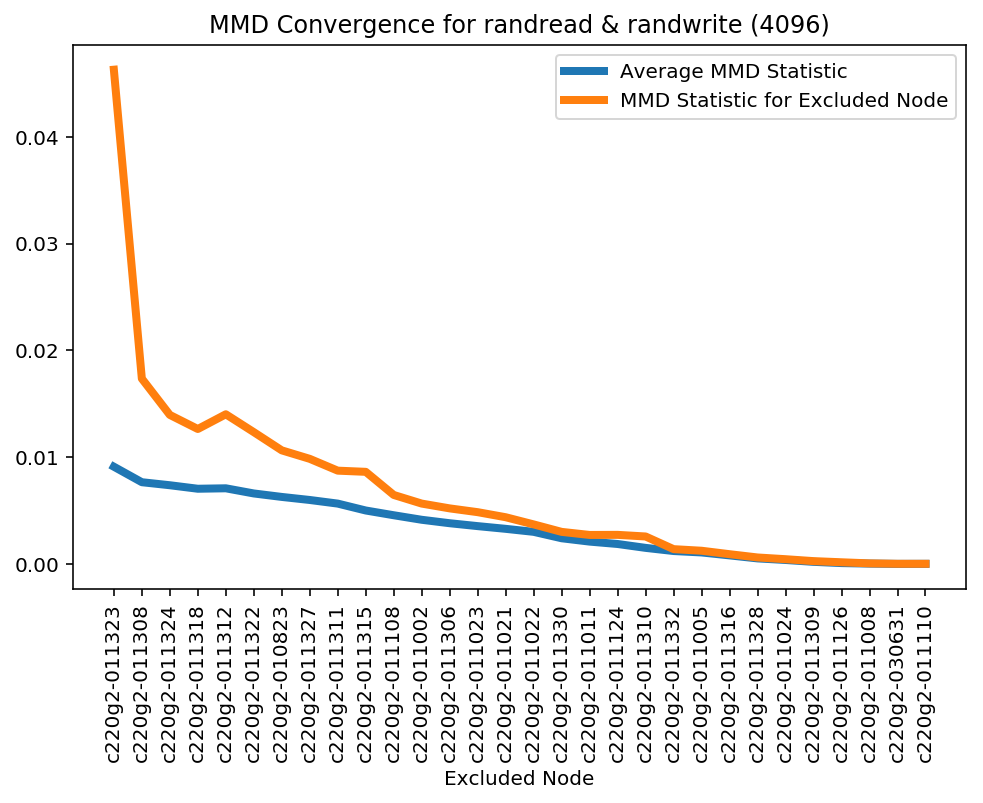

In [10]:
def plot_mmd_convergence(metrics, title):
    fig, ax = plt.subplots(figsize=(8,5))
    metrics.plot(x='Iteration', y='MMD Average', label='Average MMD Statistic', linewidth=4, ax=ax)
    metrics.plot(x='Iteration', y='MMD Excluded', label='MMD Statistic for Excluded Node', linewidth=4, ax=ax)
    ax.set_xticks(metrics["Iteration"])
    ax.set_xticklabels(metrics["Excluded"]);
    ax.set_xlabel("Excluded Node")
    ax.set_title(title)
    for item in ax.get_xticklabels():
        item.set_rotation(90)
        
plot_mmd_convergence(metrics, "MMD Convergence for randread & randwrite (4096)")

In [11]:
hw_type = "c220g2"
iodepth = 4096
count_min = 10

print "Total number of nodes:", len(disk_all["nodeid"].unique())

nodes = []
for n, n_grp in subset_df(disk_all, 
                          {"hw_type": hw_type, "device": hw2device[hw_type], 
                           "testname": "read", "iodepth": iodepth}).groupby("nodeid"):  
    if len(n_grp) >= count_min:
        nodes.append(n)
        
disk_all_selected = disk_all[disk_all["nodeid"].isin(nodes)]
print "Total number of nodes in the selected subset (with count threshold):", len(disk_all_selected["nodeid"].unique())
print "Total number of measurements in this subset:", len(disk_all_selected)

print "Starting loop"
iteration=0
metrics = []
while True:

    res = inspect_and_exclude(disk_all_selected, nodes, hw2device[hw_type], iodepth, 
                              x_dim="read", y_dim="write", kw_list=[0.05, 0.1, 0.25, 0.5])

    aggregated = res.groupby(['node']).aggregate(np.mean).sort_values(["statistic"])
    aggregated["id"] = range(len(aggregated)) 
    #display(aggregated)

    excluded_node = aggregated["statistic"].idxmax()
    print "Iteration: %d, Excluding: %s" % (iteration, excluded_node)
    
    iteration += 1
    
    aggregated
    
    disk_all_selected = disk_all_selected[disk_all_selected["nodeid"] != excluded_node]
    nodes.remove(excluded_node) 
    
    metrics.append({"Iteration": iteration, "Excluded": excluded_node, 
                    "MMD Excluded": aggregated["statistic"].max(),
                    "MMD Average": aggregated.drop([excluded_node])["statistic"].mean()})
    
    if len(nodes) == 1:
        break
        
metrics = pd.DataFrame(metrics)
display(metrics)

Total number of nodes: 835
Total number of nodes in the selected subset (with count threshold): 31
Total number of measurements in this subset: 24072
Starting loop
Iteration: 0, Excluding: c220g2-011323
Iteration: 1, Excluding: c220g2-011312
Iteration: 2, Excluding: c220g2-011308
Iteration: 3, Excluding: c220g2-011322
Iteration: 4, Excluding: c220g2-031132
Iteration: 5, Excluding: c220g2-010823
Iteration: 6, Excluding: c220g2-011324
Iteration: 7, Excluding: c220g2-011318
Iteration: 8, Excluding: c220g2-011328
Iteration: 9, Excluding: c220g2-011124
Iteration: 10, Excluding: c220g2-011002
Iteration: 11, Excluding: c220g2-011022
Iteration: 12, Excluding: c220g2-011005
Iteration: 13, Excluding: c220g2-011315
Iteration: 14, Excluding: c220g2-011108
Iteration: 15, Excluding: c220g2-011332
Iteration: 16, Excluding: c220g2-011327
Iteration: 17, Excluding: c220g2-011126
Iteration: 18, Excluding: c220g2-011110
Iteration: 19, Excluding: c220g2-011011
Iteration: 20, Excluding: c220g2-030631
Iterat

Excluded  Iteration  MMD Average  MMD Excluded
0   c220g2-011323          1     0.110955      0.432629
1   c220g2-011312          2     0.093208      0.316605
2   c220g2-011308          3     0.074999      0.253987
3   c220g2-011322          4     0.057240      0.167479
4   c220g2-031132          5     0.049307      0.147070
5   c220g2-010823          6     0.043954      0.141155
6   c220g2-011324          7     0.035905      0.141737
7   c220g2-011318          8     0.027097      0.063115
8   c220g2-011328          9     0.019832      0.048286
9   c220g2-011124         10     0.017716      0.048147
10  c220g2-011002         11     0.016010      0.037757
11  c220g2-011022         12     0.014064      0.033281
12  c220g2-011005         13     0.011380      0.028229
13  c220g2-011315         14     0.009392      0.019954
14  c220g2-011108         15     0.007562      0.016927
15  c220g2-011332         16     0.006283      0.010651
16  c220g2-011327         17     0.005770      0.008608
17  c220g2-011126         18     0.004990      0.007429
18  c220g2-011110         19     0.004524      0.006191
19  c220g2-011011         20     0.003742      0.005914
20  c220g2-030631         21     0.003306      0.005999
21  c220g2-011021         22     0.003147      0.004215
22  c220g2-011306         23     0.002948      0.003956
23  c220g2-011316         24     0.002374      0.004127
24  c220g2-011310         25     0.001906      0.003772
25  c220g2-011008         26     0.001387      0.003872
26  c220g2-011330         27     0.001126      0.001893
27  c220g2-011024         28     0.000961      0.001357
28  c220g2-011023         29     0.000680      0.001219
29  c220g2-011309         30     0.000484      0.000505

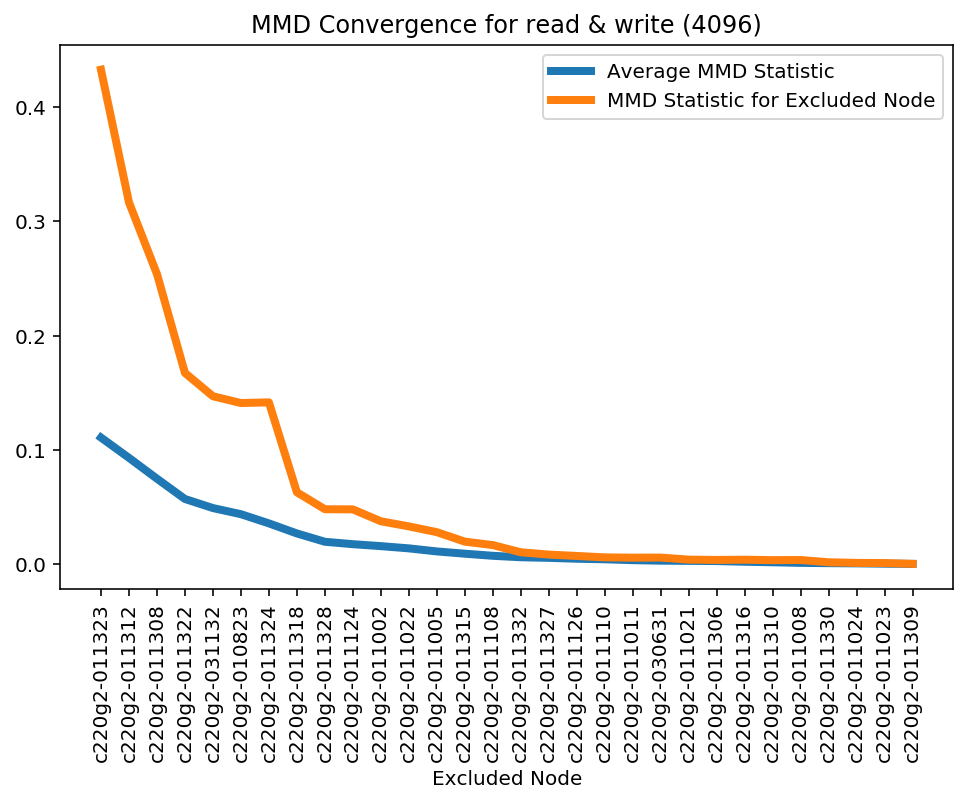

In [12]:
plot_mmd_convergence(metrics, "MMD Convergence for read & write (4096)")

In [ ]:
hw_type = "c220g2"
iodepth = 1
count_min = 10

print "Total number of nodes:", len(disk_all["nodeid"].unique())

nodes = []
for n, n_grp in subset_df(disk_all, 
                          {"hw_type": hw_type, "device": hw2device[hw_type], 
                           "testname": "read", "iodepth": iodepth}).groupby("nodeid"):  
    if len(n_grp) >= count_min:
        nodes.append(n)
        
disk_all_selected = disk_all[disk_all["nodeid"].isin(nodes)]
print "Total number of nodes in the selected subset (with count threshold):", len(disk_all_selected["nodeid"].unique())
print "Total number of measurements in this subset:", len(disk_all_selected)

print "Starting loop"
iteration=0
metrics = []
while True:

    res = inspect_and_exclude(disk_all_selected, nodes, hw2device[hw_type], iodepth, 
                              x_dim="read", y_dim="write", kw_list=[0.1, 0.25, 0.5])

    aggregated = res.groupby(['node']).aggregate(np.mean).sort_values(["statistic"])
    aggregated["id"] = range(len(aggregated)) 
    #display(aggregated)

    excluded_node = aggregated["statistic"].idxmax()
    print "Iteration: %d, Excluding: %s" % (iteration, excluded_node)
    
    iteration += 1
    
    aggregated
    
    disk_all_selected = disk_all_selected[disk_all_selected["nodeid"] != excluded_node]
    nodes.remove(excluded_node) 
    
    metrics.append({"Iteration": iteration, "Excluded": excluded_node, 
                    "MMD Excluded": aggregated["statistic"].max(),
                    "MMD Average": aggregated.drop([excluded_node])["statistic"].mean()})
    
    if len(nodes) == 1:
        break
        
metrics = pd.DataFrame(metrics)
display(metrics)

In [ ]:
plot_mmd_convergence(metrics, "MMD Convergence for read & write (1)")

In [ ]:
hw_type = "c6320"
iodepth = 4096
count_min = 10

print "Total number of nodes:", len(disk_all["nodeid"].unique())

nodes = []
for n, n_grp in subset_df(disk_all, 
                          {"hw_type": hw_type, "device": hw2device[hw_type], 
                           "testname": "randread", "iodepth": iodepth}).groupby("nodeid"):  
    if len(n_grp) >= count_min:
        nodes.append(n)
        
disk_all_selected = disk_all[disk_all["nodeid"].isin(nodes)]
print "Total number of nodes in the selected subset (with count threshold):", len(disk_all_selected["nodeid"].unique())
print "Total number of measurements in this subset:", len(disk_all_selected)

print "Starting loop"
iteration=0
metrics = []
while True:

    res = inspect_and_exclude(disk_all_selected, nodes, hw2device[hw_type], iodepth, 
                              x_dim="randread", y_dim="randwrite", kw_list=[0.1, 0.25, 0.5])

    aggregated = res.groupby(['node']).aggregate(np.mean).sort_values(["statistic"])
    aggregated["id"] = range(len(aggregated)) 
    #display(aggregated)

    excluded_node = aggregated["statistic"].idxmax()
    print "Iteration: %d, Excluding: %s" % (iteration, excluded_node)
    
    iteration += 1
    
    aggregated
    
    disk_all_selected = disk_all_selected[disk_all_selected["nodeid"] != excluded_node]
    nodes.remove(excluded_node) 
    
    metrics.append({"Iteration": iteration, "Excluded": excluded_node, 
                    "MMD Excluded": aggregated["statistic"].max(),
                    "MMD Average": aggregated.drop([excluded_node])["statistic"].mean()})
    
    if len(nodes) == 1:
        break
        
metrics = pd.DataFrame(metrics)
display(metrics)

In [ ]:
plot_mmd_convergence(metrics, "MMD Convergence for randread & randwrite (4096)")

In [ ]:
# Memory testing in 2D

#mem_all = mem_all[mem_all["run_success"] == 1]

def scale_median(data_p, data_q):
    # Scale: divide by median of the combined sample (which includes both data from p and q)    
    #print len(data_p[0]), len(data_p[1]), len(data_q[0]), len(data_q[1]) 
    
    x_med = np.median(np.concatenate([data_p[0], data_q[0]]))
    y_med = np.median(np.concatenate([data_p[1], data_q[1]]))
    
    
    data_p_scaled = sg.RealFeatures(np.vstack( (list(np.array(data_p[0]) / x_med), 
                                                list(np.array(data_p[1]) / y_med) ))) 
    
    data_q_scaled = sg.RealFeatures(np.vstack( (list(np.array(data_q[0]) / x_med), 
                                                list(np.array(data_q[1]) / y_med) ))) 
    
    return data_p_scaled, data_q_scaled


def compare_individual_and_combined(df_all, nodes, hw_type, 
                x_testname="copy", x_dvfs="no", x_socket_num=0,
                y_testname="copy_omp", y_dvfs="no", y_socket_num=0,
                metric = "mean", alpha=0.05, train_test_ratio=1,
                kw_list=[0.5, 0.25, 0.1, 0.05, 0.025]):
    data = []

    x_combined = subset_df(df_all, {"hw_type": hw_type, "testname": x_testname, "dvfs": x_dvfs, "socket_num": x_socket_num})   
    #print "Length of x combined:", len(x_combined)
    #print x_combined.nodeid.value_counts()
    y_combined = subset_df(df_all, {"hw_type": hw_type, "testname": y_testname, "dvfs": y_dvfs, "socket_num": y_socket_num})
    #print "Length of y combined:", len(y_combined)  
    #print y_combined.nodeid.value_counts()
        
    for idx2, n2 in enumerate(nodes):
        
        n1_data = [x_combined[x_combined["nodeid"] != n2][metric].tolist(), 
                   y_combined[y_combined["nodeid"] != n2][metric].tolist()]
    
        n2_data = [subset_df(df_all, {"nodeid": n2, "testname": x_testname, "dvfs": x_dvfs, "socket_num": x_socket_num})[metric].tolist(),
                   subset_df(df_all, {"nodeid": n2, "testname": y_testname, "dvfs": y_dvfs, "socket_num": y_socket_num})[metric].tolist()]

        # scaling
        n1_data_scaled, n2_data_scaled = scale_median(n1_data, n2_data) 
        n1_data = n1_data_scaled
        n2_data = n2_data_scaled

        fig, ax1 = plt.subplots(figsize=(6,3))

        ax1.plot(n1_data[0], n1_data[1], 'ro', markersize=2, label='$x$')
        ax1.plot(n2_data[0], n2_data[1], 'bs', markersize=2, label='$x$', alpha=0.5)

        # Plot styling
        ax1.legend(["%s (%d samples)" % ("The rest", len(n1_data[0])), "%s (%d samples)" % (n2, len(n2_data[0]))],)
        ax1.grid(True)
        ax1.set_xlabel("%s,%s,%s" % (x_testname, x_dvfs, x_socket_num))
        ax1.set_ylabel("%s,%s,%s" % (y_testname, y_dvfs, y_socket_num))

        results = mmd_quadratic_statistic_only(sg.RealFeatures(np.vstack((n1_data[0], n1_data[1]))), 
                                    sg.RealFeatures(np.vstack((n2_data[0], n2_data[1]))),
                                            kw_list=kw_list)

        display(pd.DataFrame(results))

        plot_show_and_save(fig, show_only=True)

hw_type = "c220g2"
dvfs = "no"
socket_num = 0
count_min = 10

### Get all nodes with >=count_min samples
# nodes = []
# for n, n_grp in subset_df(mem_all, 
#                           {"hw_type": hw_type, "testname": "copy", 
#                            "dvfs": dvfs, "socket_num": socket_num}).groupby("nodeid"):  
#     if len(n_grp) >= count_min:
#         nodes.append(n)

# print nodes

# Instead of all nodes, use a specific list
nodes = ["c220g2-011312", "c220g2-010823", "c220g2-011330"]
        
compare_individual_and_combined(mem_all, nodes, hw_type, kw_list=[0.1, 0.25, 0.5])

In [ ]:
def inspect_and_exclude(df_all, nodes, hw_type, 
                x_testname="copy", x_dvfs="no", x_socket_num=0,
                y_testname="copy_omp", y_dvfs="no", y_socket_num=0,
                metric = "mean",
                kw_list=[0.5, 0.25, 0.1, 0.05, 0.025]):
    data = []

    x_combined = subset_df(df_all, {"hw_type": hw_type, "testname": x_testname, "dvfs": x_dvfs, "socket_num": x_socket_num})   
    y_combined = subset_df(df_all, {"hw_type": hw_type, "testname": y_testname, "dvfs": y_dvfs, "socket_num": y_socket_num})
        
    res = pd.DataFrame()
    for idx2, n2 in enumerate(nodes):

        n1_data = [x_combined[x_combined["nodeid"] != n2][metric].tolist(), 
                   y_combined[y_combined["nodeid"] != n2][metric].tolist()]
    
        n2_data = [subset_df(df_all, {"nodeid": n2, "testname": x_testname, "dvfs": x_dvfs, "socket_num": x_socket_num})[metric].tolist(),
                   subset_df(df_all, {"nodeid": n2, "testname": y_testname, "dvfs": y_dvfs, "socket_num": y_socket_num})[metric].tolist()]

        # scaling
        n1_data_scaled, n2_data_scaled = scale_median(n1_data, n2_data) 
        n1_data = n1_data_scaled
        n2_data = n2_data_scaled

        results = mmd_quadratic_statistic_only(sg.RealFeatures(np.vstack((n1_data[0], n1_data[1]))), 
                                    sg.RealFeatures(np.vstack((n2_data[0], n2_data[1]))),
                                            kw_list=kw_list)
        results = pd.DataFrame(results)
        results["node"] = n2

        res = pd.concat([res, results])
        
    return res

hw_type = "c220g2"
dvfs = "no"
socket_num = 0
count_min = 10

print "Total number of nodes:", len(mem_all["nodeid"].unique())


nodes = []
for n, n_grp in subset_df(mem_all, 
                          {"hw_type": hw_type, "testname": "copy", 
                           "dvfs": dvfs, "socket_num": socket_num}).groupby("nodeid"):  
    if len(n_grp) >= count_min:
        nodes.append(n)
        
mem_all_selected = mem_all[mem_all["nodeid"].isin(nodes)]
print "Total number of nodes in the selected subset (with count threshold):", len(mem_all_selected["nodeid"].unique())
print "Total number of measurements in this subset:", len(mem_all_selected)

print "Starting loop"
iteration=0
metrics = []
while True:

    res = inspect_and_exclude(mem_all_selected, nodes, hw_type, kw_list=[0.1, 0.25, 0.5])

    aggregated = res.groupby(['node']).aggregate(np.mean).sort_values(["statistic"])
    aggregated["id"] = range(len(aggregated)) 
    #display(aggregated)

    excluded_node = aggregated["statistic"].idxmax()
    print "Iteration: %d, Excluding: %s" % (iteration, excluded_node)
    
    iteration += 1
    
    aggregated
    
    disk_all_selected = disk_all_selected[disk_all_selected["nodeid"] != excluded_node]
    nodes.remove(excluded_node) 
    
    metrics.append({"Iteration": iteration, "Excluded": excluded_node, 
                    "MMD Excluded": aggregated["statistic"].max(),
                    "MMD Average": aggregated.drop([excluded_node])["statistic"].mean()})
    
    if len(nodes) == 1:
        break
        
metrics = pd.DataFrame(metrics)
display(metrics)

In [ ]:
plot_mmd_convergence(metrics, "MMD Convergence for randread & randwrite (4096)")

In [ ]:
# Testing in many dimensions

def scale_nd(data_p, data_q):
    # Scale: divide by median of the combined sample (which includes both data from p and q)  
    
    if data_p.get_num_features() != data_q.get_num_features(): 
        print "scale_nd: mismatch in the number of features in compared samples" 
    
    nd = data_p.get_num_features()
    
    med_vals = [np.median(np.concatenate([data_p[idx], data_q[idx]])) for idx in range(nd)]
    
    #print "scale_nd: medians -- ", med_vals 
    
    data_p_scaled = sg.RealFeatures(np.vstack([list(np.array(data_p[idx]) / med_vals[idx]) for idx in range(nd)]))
    data_q_scaled = sg.RealFeatures(np.vstack([list(np.array(data_q[idx]) / med_vals[idx]) for idx in range(nd)]))
    
    return data_p_scaled, data_q_scaled

def mmd_quadratic_statistic_only(data_p, data_q, kw_list):
    """ Run multiple quadratic time MMD tests with different kernel widths"""
    
    #print "MMD Quadratic"
    #print data_p[0], data_p[1], data_p[2], data_p[3]
    #print data_q[0], data_q[1], data_q[2], data_q[3]
    
    results = []
    for kw in kw_list:

        mmd = sg.QuadraticTimeMMD(data_p, data_q)
        mmd.set_kernel(sg.GaussianKernel(10, kw))

        # compute biased and unbiased test statistic (default is unbiased)
        #mmd.set_statistic_type(sg.ST_UNBIASED_FULL)
        mmd.set_statistic_type(sg.ST_BIASED_FULL)
        statistic = mmd.compute_statistic()
        
        results.append({"mmd_type": "quadratic",
                        "kernel_width": kw, 
                        "statistic": statistic})
    return results

def select_features(disk_df, mem_df, metric="mean"):
    
    d1_df = subset_df(disk_df, {"device": "/dev/sdc", "testname": "randread", "iodepth": 4096}) 
    d2_df = subset_df(disk_df, {"device": "/dev/sdc", "testname": "randwrite", "iodepth": 4096}) 
    d3_df = subset_df(mem_df, {"testname": "copy", "dvfs": "no", "socket_num": 0})
    d4_df = subset_df(mem_df, {"testname": "copy_omp", "dvfs": "no", "socket_num": 0})
    
    #print "Length:", [len(df) for df in [d1_df, d2_df, d3_df, d4_df]]
    min_len = np.array([len(df) for df in [d1_df, d2_df, d3_df, d4_df]]).min()
    #print "Min Length:", min_len
    
    #return [df[metric].tolist()[:min_len] for df in [d1_df, d2_df, d3_df, d4_df]]
    return sg.RealFeatures(np.vstack([df[metric].tolist()[:min_len] for df in [d1_df, d2_df, d3_df, d4_df]]))

hw_type="c220g2"
run_count = 1

disk_subset = disk_all[disk_all["hw_type"]==hw_type]
mem_subset = mem_all[mem_all["hw_type"]==hw_type]
mixed_features = select_features(disk_subset, mem_subset)

disk_nodes = set(disk_subset.nodeid.unique())
mem_nodes = set(mem_subset.nodeid.unique())
# This is just to check that there is no difference in node lists for disk and memory datasets; should be empty sets
print disk_nodes - mem_nodes
print mem_nodes - disk_nodes

node_scores = pd.DataFrame()
for n, grp in disk_subset.groupby(["nodeid"]):
    
    mem_corresponding = mem_subset[mem_subset["nodeid"]==n]
    disk_run_count = len(grp.run_uuid.unique())
    mem_run_count = len(mem_corresponding.run_uuid.unique())
    
    #if disk_run_count != mem_run_count:
        #print "Mismatch between disk and memory runs:", n, disk_run_count, mem_run_count  
        #print grp.run_uuid.unique(), mem_corresponding.run_uuid.unique()
        
    if disk_run_count >= run_count and mem_run_count >= run_count:
        #print "Selecting node for kernel analysis", n, "; Number of disk and memory runs:", disk_run_count, mem_run_count 
        
        disk_runs = set(grp.run_uuid.unique())
        mem_runs = set(mem_corresponding.run_uuid.unique())
        matching_runs = disk_runs.intersection(mem_runs)
    
        disk_matching = grp[grp["run_uuid"].isin(matching_runs)] 
        mem_matching = mem_corresponding[mem_corresponding["run_uuid"].isin(matching_runs)] 
        
        node_features = select_features(disk_matching, mem_matching)
        if len(node_features[0]) > 0:
            
            disk_subset_excluded = disk_subset[disk_subset["nodeid"] != n]
            mem_subset_excluded = mem_subset[mem_subset["nodeid"] != n]
            mixed_features_excluded = select_features(disk_subset_excluded, mem_subset_excluded)
            
            node_features_scaled, mixed_features_scaled = scale_nd(node_features, mixed_features_excluded) 

            #results = mmd_quadratic_statistic_only(node_features_scaled, mixed_features_scaled,
            #                                    kw_list=[0.1, 0.25, 0.5])
            
            # Use single kernel width
            results = mmd_quadratic_statistic_only(node_features_scaled, mixed_features_scaled,
                                                kw_list=[0.5])
            
            results = pd.DataFrame(results)
            results["node"] = n
            results["samples"] = len(node_features[0])
            #display(results)
            
            node_scores = pd.concat([node_scores, results])
        
        else:
            pass
            #print "Not enough data for the node's selected features. Skipping node:", n

#print len(disk_all[disk_all["nodeid"]=="c220g2-011312"].run_uuid.unique())
#print len(mem_all[mem_all["nodeid"]=="c220g2-011312"].run_uuid.unique())

display(node_scores)

In [ ]:
aggregated = node_scores.groupby(['node']).aggregate(np.mean).sort_values(["statistic"])
aggregated["id"] = range(len(aggregated)) 
#display(aggregated)

print "'Worst' node:", aggregated["statistic"].idxmax()

fig, ax = plt.subplots(figsize=(16,3))
aggregated.plot(x='id', y='statistic', label="Quadratic MMD Statistic", ax=ax)
ax.set_xticks(aggregated['id'])
ax.set_xticklabels(["%s (%d)" % (n,c) for (n,c) in zip(aggregated.index, aggregated["samples"])]);
ax.set_xlabel("Analyzed Node")
for item in ax.get_xticklabels():
    item.set_rotation(90)

aggregated_worst_dropped = aggregated.drop(aggregated["statistic"].idxmax(), inplace=False)
fig, ax = plt.subplots(figsize=(16,3))
aggregated_worst_dropped.plot(x='id', y='statistic', label="Quadratic MMD Statistic", ax=ax)
ax.set_xticks(aggregated_worst_dropped['id'])
ax.set_xticklabels(["%s (%d)" % (n,c) for (n,c) in zip(aggregated_worst_dropped.index, aggregated_worst_dropped["samples"])]);
ax.set_xlabel("Analyzed Node")
for item in ax.get_xticklabels():
    item.set_rotation(90)

In [ ]:
hw_type="c220g2"
run_count = 1

disk_subset = disk_all[disk_all["hw_type"]==hw_type]
mem_subset = mem_all[mem_all["hw_type"]==hw_type]
mixed_features = select_features(disk_subset, mem_subset)


print "Starting loop"
iteration=0
metrics = []
while True:

    node_scores = pd.DataFrame()
    for n, grp in disk_subset.groupby(["nodeid"]):

        mem_corresponding = mem_subset[mem_subset["nodeid"]==n]
        disk_run_count = len(grp.run_uuid.unique())
        mem_run_count = len(mem_corresponding.run_uuid.unique())

        #if disk_run_count != mem_run_count:
            #print "Mismatch between disk and memory runs:", n, disk_run_count, mem_run_count  
            #print grp.run_uuid.unique(), mem_corresponding.run_uuid.unique()

        if disk_run_count >= run_count and mem_run_count >= run_count:
            #print "Selecting node for kernel analysis", n, "; Number of disk and memory runs:", disk_run_count, mem_run_count 

            disk_runs = set(grp.run_uuid.unique())
            mem_runs = set(mem_corresponding.run_uuid.unique())
            matching_runs = disk_runs.intersection(mem_runs)

            disk_matching = grp[grp["run_uuid"].isin(matching_runs)] 
            mem_matching = mem_corresponding[mem_corresponding["run_uuid"].isin(matching_runs)] 

            node_features = select_features(disk_matching, mem_matching)
            if len(node_features[0]) > 0:

                disk_subset_excluded = disk_subset[disk_subset["nodeid"] != n]
                mem_subset_excluded = mem_subset[mem_subset["nodeid"] != n]
                mixed_features_excluded = select_features(disk_subset_excluded, mem_subset_excluded)

                node_features_scaled, mixed_features_scaled = scale_nd(node_features, mixed_features_excluded) 

                results = mmd_quadratic_statistic_only(node_features_scaled, mixed_features_scaled,
                                                    kw_list=[0.25])
                results = pd.DataFrame(results)
                results["node"] = n
                results["samples"] = len(node_features[0])
                #display(results)

                node_scores = pd.concat([node_scores, results])

            else:
                pass
                #print "Not enough data for the node's selected features. Skipping node:", n

    aggregated = node_scores.groupby(['node']).aggregate(np.mean).sort_values(["statistic"])

    aggregated["id"] = range(len(aggregated)) 

    excluded_node = aggregated["statistic"].idxmax()
    print "Iteration: %d, Excluding: %s" % (iteration, excluded_node)

    iteration += 1

    disk_subset = disk_subset[disk_subset["nodeid"] != excluded_node]

    metrics.append({"Iteration": iteration, "Excluded": excluded_node, 
                    "MMD Excluded": aggregated["statistic"].max(),
                    "MMD Average": aggregated.drop([excluded_node])["statistic"].mean()})
    
    if len(disk_subset.nodeid.unique()) == 1:
        break
        
metrics = pd.DataFrame(metrics)
display(metrics)              

In [ ]:
metrics = pd.DataFrame(metrics)
display(metrics) 

def plot_mmd_convergence(metrics, title):
    fig, ax = plt.subplots(figsize=(17,3))
    metrics.plot(x='Iteration', y='MMD Average', label='Average MMD Statistic', linewidth=4, ax=ax)
    metrics.plot(x='Iteration', y='MMD Excluded', label='MMD Statistic for Excluded Node', linewidth=4, ax=ax)
    ax.set_xticks(metrics["Iteration"])
    ax.set_xticklabels(metrics["Excluded"]);
    ax.set_xlabel("Excluded Node")
    ax.set_title(title)
    for item in ax.get_xticklabels():
        item.set_rotation(90)

plot_mmd_convergence(metrics, "MMD Convergence for c220g2 in 4D")

worst_node = metrics['MMD Excluded'].idxmax()
metrics_worst_dropped = metrics.drop(worst_node, inplace=False)

plot_mmd_convergence(metrics_worst_dropped, "MMD Convergence for c220g2 in 4D (worst node excluded)")

In [ ]:
def select_features(disk_df, mem_df, metric="mean"):
    
    df = [
        subset_df(disk_df, {"device": "/dev/sdc", "testname": "randread", "iodepth": 4096}),
        subset_df(disk_df, {"device": "/dev/sdc", "testname": "randwrite", "iodepth": 4096}), 
        subset_df(mem_df, {"testname": "copy", "dvfs": "no", "socket_num": 0}),
        subset_df(mem_df, {"testname": "copy", "dvfs": "no", "socket_num": 1}),
        ]
    
    #print "Length:", [len(df) for df in [d1_df, d2_df, d3_df, d4_df]]
    min_len = np.array([len(x) for x in df]).min()
    #print "Min Length:", min_len
    
    #return [df[metric].tolist()[:min_len] for df in [d1_df, d2_df, d3_df, d4_df]]
    return sg.RealFeatures(np.vstack([x[metric].tolist()[:min_len] for x in df]))

hw_type="c220g2"
run_count = 1

disk_subset = disk_all[disk_all["hw_type"]==hw_type]
mem_subset = mem_all[mem_all["hw_type"]==hw_type]
mixed_features = select_features(disk_subset, mem_subset)

print "Starting loop"
iteration=0
metrics = []
while True:

    node_scores = pd.DataFrame()
    for n, grp in disk_subset.groupby(["nodeid"]):

        mem_corresponding = mem_subset[mem_subset["nodeid"]==n]
        disk_run_count = len(grp.run_uuid.unique())
        mem_run_count = len(mem_corresponding.run_uuid.unique())

        #if disk_run_count != mem_run_count:
            #print "Mismatch between disk and memory runs:", n, disk_run_count, mem_run_count  
            #print grp.run_uuid.unique(), mem_corresponding.run_uuid.unique()

        if disk_run_count >= run_count and mem_run_count >= run_count:
            #print "Selecting node for kernel analysis", n, "; Number of disk and memory runs:", disk_run_count, mem_run_count 

            disk_runs = set(grp.run_uuid.unique())
            mem_runs = set(mem_corresponding.run_uuid.unique())
            matching_runs = disk_runs.intersection(mem_runs)

            disk_matching = grp[grp["run_uuid"].isin(matching_runs)] 
            mem_matching = mem_corresponding[mem_corresponding["run_uuid"].isin(matching_runs)] 

            node_features = select_features(disk_matching, mem_matching)
            if len(node_features[0]) > 0:

                disk_subset_excluded = disk_subset[disk_subset["nodeid"] != n]
                mem_subset_excluded = mem_subset[mem_subset["nodeid"] != n]
                mixed_features_excluded = select_features(disk_subset_excluded, mem_subset_excluded)

                node_features_scaled, mixed_features_scaled = scale_nd(node_features, mixed_features_excluded) 

                results = mmd_quadratic_statistic_only(node_features_scaled, mixed_features_scaled,
                                                    kw_list=[0.25])
                results = pd.DataFrame(results)
                results["node"] = n
                results["samples"] = len(node_features[0])
                #display(results)

                node_scores = pd.concat([node_scores, results])

            else:
                pass
                #print "Not enough data for the node's selected features. Skipping node:", n

    aggregated = node_scores.groupby(['node']).aggregate(np.mean).sort_values(["statistic"])

    aggregated["id"] = range(len(aggregated)) 

    excluded_node = aggregated["statistic"].idxmax()
    print "Iteration: %d, Excluding: %s" % (iteration, excluded_node)

    iteration += 1

    disk_subset = disk_subset[disk_subset["nodeid"] != excluded_node]

    metrics.append({"Iteration": iteration, "Excluded": excluded_node, 
                    "MMD Excluded": aggregated["statistic"].max(),
                    "MMD Average": aggregated.drop([excluded_node])["statistic"].mean()})
    
    if len(disk_subset.nodeid.unique()) == 1:
        break
        
metrics = pd.DataFrame(metrics)
display(metrics)              

In [ ]:
metrics = pd.DataFrame(metrics)
display(metrics) 

plot_mmd_convergence(metrics, "MMD Convergence for c220g2 in 4D")

worst_node = metrics['MMD Excluded'].idxmax()
metrics_worst_dropped = metrics.drop(worst_node, inplace=False)

plot_mmd_convergence(metrics_worst_dropped, "MMD Convergence for c220g2 in 4D (worst node excluded)")

In [ ]:
hw2device = {"c220g1": "/dev/sda4",
             "c220g2": "/dev/sda4",
             "c6320": "/dev/sda4",
             "c8220": "/dev/sda4",
             "m400": "/dev/sda2",
             "m510": "/dev/nvme0n1p4"}

def select_features(disk_df, mem_df, metric="mean"):
    
    df = [
        subset_df(disk_df, {"device": "/dev/sda4", "testname": "randread", "iodepth": 4096}),
        subset_df(disk_df, {"device": "/dev/sda4", "testname": "randwrite", "iodepth": 4096}), 
        subset_df(disk_df, {"device": "/dev/sda4", "testname": "read", "iodepth": 4096}),
        subset_df(disk_df, {"device": "/dev/sda4", "testname": "write", "iodepth": 4096}), 
        subset_df(mem_df, {"testname": "copy", "dvfs": "yes", "socket_num": 0}),
        subset_df(mem_df, {"testname": "copy_omp", "dvfs": "yes", "socket_num": 0}),
        subset_df(mem_df, {"testname": "triad", "dvfs": "yes", "socket_num": 0}),
        subset_df(mem_df, {"testname": "triad_omp", "dvfs": "yes", "socket_num": 0}),
        ]
    
    #print "Length:", [len(df) for df in [d1_df, d2_df, d3_df, d4_df]]
    min_len = np.array([len(x) for x in df]).min()
    #print "Min Length:", min_len
    
    #return [df[metric].tolist()[:min_len] for df in [d1_df, d2_df, d3_df, d4_df]]
    return sg.RealFeatures(np.vstack([x[metric].tolist()[:min_len] for x in df]))

hw_type="c220g2"
run_count = 1

disk_subset = disk_all[disk_all["hw_type"]==hw_type]
mem_subset = mem_all[mem_all["hw_type"]==hw_type]
mixed_features = select_features(disk_subset, mem_subset)

print "Starting loop"
iteration=0
metrics = []
while True:

    node_scores = pd.DataFrame()
    for n, grp in disk_subset.groupby(["nodeid"]):

        mem_corresponding = mem_subset[mem_subset["nodeid"]==n]
        disk_run_count = len(grp.run_uuid.unique())
        mem_run_count = len(mem_corresponding.run_uuid.unique())

        #if disk_run_count != mem_run_count:
            #print "Mismatch between disk and memory runs:", n, disk_run_count, mem_run_count  
            #print grp.run_uuid.unique(), mem_corresponding.run_uuid.unique()

        if disk_run_count >= run_count and mem_run_count >= run_count:
            #print "Selecting node for kernel analysis", n, "; Number of disk and memory runs:", disk_run_count, mem_run_count 

            disk_runs = set(grp.run_uuid.unique())
            mem_runs = set(mem_corresponding.run_uuid.unique())
            matching_runs = disk_runs.intersection(mem_runs)

            disk_matching = grp[grp["run_uuid"].isin(matching_runs)] 
            mem_matching = mem_corresponding[mem_corresponding["run_uuid"].isin(matching_runs)] 

            node_features = select_features(disk_matching, mem_matching)
            if len(node_features[0]) > 0:

                disk_subset_excluded = disk_subset[disk_subset["nodeid"] != n]
                mem_subset_excluded = mem_subset[mem_subset["nodeid"] != n]
                mixed_features_excluded = select_features(disk_subset_excluded, mem_subset_excluded)

                node_features_scaled, mixed_features_scaled = scale_nd(node_features, mixed_features_excluded) 

                results = mmd_quadratic_statistic_only(node_features_scaled, mixed_features_scaled,
                                                    kw_list=[0.25])
                results = pd.DataFrame(results)
                results["node"] = n
                results["samples"] = len(node_features[0])
                #display(results)

                node_scores = pd.concat([node_scores, results])

            else:
                pass
                #print "Not enough data for the node's selected features. Skipping node:", n

    aggregated = node_scores.groupby(['node']).aggregate(np.mean).sort_values(["statistic"])

    aggregated["id"] = range(len(aggregated)) 

    excluded_node = aggregated["statistic"].idxmax()
    print "Iteration: %d, Excluding: %s" % (iteration, excluded_node)

    iteration += 1

    disk_subset = disk_subset[disk_subset["nodeid"] != excluded_node]

    metrics.append({"Iteration": iteration, "Excluded": excluded_node, 
                    "MMD Excluded": aggregated["statistic"].max(),
                    "MMD Average": aggregated.drop([excluded_node])["statistic"].mean()})
    
    if len(disk_subset.nodeid.unique()) == 2:
        break
    
    if iteration >= 10:
        break
        
metrics = pd.DataFrame(metrics)
display(metrics)              

In [ ]:
plot_mmd_convergence(metrics, "MMD Convergence for c220g2 in 4D")

worst_node = metrics['MMD Excluded'].idxmax()
metrics_worst_dropped = metrics.drop(worst_node, inplace=False)

plot_mmd_convergence(metrics_worst_dropped, "MMD Convergence for c220g2 in 4D (worst node excluded)")

In [ ]:
hw2device = {"c220g1": "/dev/sda4",
             "c220g2": "/dev/sda4",
             "c6320": "/dev/sda4",
             "c8220": "/dev/sda4",
             "m400": "/dev/sda2",
             "m510": "/dev/nvme0n1p4"}

def select_features(disk_df, mem_df, metric="mean"):
    
    df = [
        subset_df(disk_df, {"device": "/dev/sda4", "testname": "randread", "iodepth": 4096}),
        subset_df(disk_df, {"device": "/dev/sda4", "testname": "randwrite", "iodepth": 4096}), 
        subset_df(disk_df, {"device": "/dev/sda4", "testname": "read", "iodepth": 4096}),
        subset_df(disk_df, {"device": "/dev/sda4", "testname": "write", "iodepth": 4096}), 
        subset_df(mem_df, {"testname": "copy", "dvfs": "yes", "socket_num": 0}),
        subset_df(mem_df, {"testname": "copy_omp", "dvfs": "yes", "socket_num": 0}),
        subset_df(mem_df, {"testname": "triad", "dvfs": "yes", "socket_num": 0}),
        subset_df(mem_df, {"testname": "triad_omp", "dvfs": "yes", "socket_num": 0}),
        ]
    
    #print "Length:", [len(df) for df in [d1_df, d2_df, d3_df, d4_df]]
    min_len = np.array([len(x) for x in df]).min()
    #print "Min Length:", min_len
    
    #return [df[metric].tolist()[:min_len] for df in [d1_df, d2_df, d3_df, d4_df]]
    return sg.RealFeatures(np.vstack([x[metric].tolist()[:min_len] for x in df]))

hw_type="c220g1"
run_count = 1

disk_subset = disk_all[disk_all["hw_type"]==hw_type]
mem_subset = mem_all[mem_all["hw_type"]==hw_type]
mixed_features = select_features(disk_subset, mem_subset)

print "Starting loop"
iteration=0
metrics = []
while True:

    node_scores = pd.DataFrame()
    for n, grp in disk_subset.groupby(["nodeid"]):

        mem_corresponding = mem_subset[mem_subset["nodeid"]==n]
        disk_run_count = len(grp.run_uuid.unique())
        mem_run_count = len(mem_corresponding.run_uuid.unique())

        #if disk_run_count != mem_run_count:
            #print "Mismatch between disk and memory runs:", n, disk_run_count, mem_run_count  
            #print grp.run_uuid.unique(), mem_corresponding.run_uuid.unique()

        if disk_run_count >= run_count and mem_run_count >= run_count:
            #print "Selecting node for kernel analysis", n, "; Number of disk and memory runs:", disk_run_count, mem_run_count 

            disk_runs = set(grp.run_uuid.unique())
            mem_runs = set(mem_corresponding.run_uuid.unique())
            matching_runs = disk_runs.intersection(mem_runs)

            disk_matching = grp[grp["run_uuid"].isin(matching_runs)] 
            mem_matching = mem_corresponding[mem_corresponding["run_uuid"].isin(matching_runs)] 

            node_features = select_features(disk_matching, mem_matching)
            if len(node_features[0]) > 0:

                disk_subset_excluded = disk_subset[disk_subset["nodeid"] != n]
                mem_subset_excluded = mem_subset[mem_subset["nodeid"] != n]
                mixed_features_excluded = select_features(disk_subset_excluded, mem_subset_excluded)

                node_features_scaled, mixed_features_scaled = scale_nd(node_features, mixed_features_excluded) 

                results = mmd_quadratic_statistic_only(node_features_scaled, mixed_features_scaled,
                                                    kw_list=[0.25])
                results = pd.DataFrame(results)
                results["node"] = n
                results["samples"] = len(node_features[0])
                #display(results)

                node_scores = pd.concat([node_scores, results])

            else:
                pass
                #print "Not enough data for the node's selected features. Skipping node:", n

    aggregated = node_scores.groupby(['node']).aggregate(np.mean).sort_values(["statistic"])

    aggregated["id"] = range(len(aggregated)) 

    excluded_node = aggregated["statistic"].idxmax()
    print "Iteration: %d, Excluding: %s" % (iteration, excluded_node)

    iteration += 1

    disk_subset = disk_subset[disk_subset["nodeid"] != excluded_node]

    metrics.append({"Iteration": iteration, "Excluded": excluded_node, 
                    "MMD Excluded": aggregated["statistic"].max(),
                    "MMD Average": aggregated.drop([excluded_node])["statistic"].mean()})
    
    if len(disk_subset.nodeid.unique()) == 2:
        break
    
    if iteration >= 10:
        break
        
metrics = pd.DataFrame(metrics)
display(metrics)              

In [ ]:
plot_mmd_convergence(metrics, "MMD Convergence for c220g1 in 8D")

worst_node = metrics['MMD Excluded'].idxmax()
metrics_worst_dropped = metrics.drop(worst_node, inplace=False)

plot_mmd_convergence(metrics_worst_dropped, "MMD Convergence for c220g1 in 8D (worst node excluded)")

In [ ]:
hw2device = {"c220g1": "/dev/sda4",
             "c220g2": "/dev/sda4",
             "c6320": "/dev/sda4",
             "c8220": "/dev/sda4",
             "m400": "/dev/sda2",
             "m510": "/dev/nvme0n1p4"}

def select_features(disk_df, mem_df, metric="mean"):
    
    df = [
        subset_df(disk_df, {"device": "/dev/sda4", "testname": "randread", "iodepth": 4096}),
        subset_df(disk_df, {"device": "/dev/sda4", "testname": "randwrite", "iodepth": 4096}), 
        subset_df(disk_df, {"device": "/dev/sda4", "testname": "read", "iodepth": 4096}),
        subset_df(disk_df, {"device": "/dev/sda4", "testname": "write", "iodepth": 4096}), 
        subset_df(mem_df, {"testname": "copy", "dvfs": "yes", "socket_num": 0}),
        subset_df(mem_df, {"testname": "copy_omp", "dvfs": "yes", "socket_num": 0}),
        subset_df(mem_df, {"testname": "triad", "dvfs": "yes", "socket_num": 0}),
        subset_df(mem_df, {"testname": "triad_omp", "dvfs": "yes", "socket_num": 0}),
        ]
    
    #print "Length:", [len(df) for df in [d1_df, d2_df, d3_df, d4_df]]
    min_len = np.array([len(x) for x in df]).min()
    #print "Min Length:", min_len
    
    #return [df[metric].tolist()[:min_len] for df in [d1_df, d2_df, d3_df, d4_df]]
    return sg.RealFeatures(np.vstack([x[metric].tolist()[:min_len] for x in df]))

hw_type="c8220"
run_count = 1

disk_subset = disk_all[disk_all["hw_type"]==hw_type]
mem_subset = mem_all[mem_all["hw_type"]==hw_type]
mixed_features = select_features(disk_subset, mem_subset)

print "Starting loop"
iteration=0
metrics = []
while True:

    node_scores = pd.DataFrame()
    for n, grp in disk_subset.groupby(["nodeid"]):

        mem_corresponding = mem_subset[mem_subset["nodeid"]==n]
        disk_run_count = len(grp.run_uuid.unique())
        mem_run_count = len(mem_corresponding.run_uuid.unique())

        #if disk_run_count != mem_run_count:
            #print "Mismatch between disk and memory runs:", n, disk_run_count, mem_run_count  
            #print grp.run_uuid.unique(), mem_corresponding.run_uuid.unique()

        if disk_run_count >= run_count and mem_run_count >= run_count:
            #print "Selecting node for kernel analysis", n, "; Number of disk and memory runs:", disk_run_count, mem_run_count 

            disk_runs = set(grp.run_uuid.unique())
            mem_runs = set(mem_corresponding.run_uuid.unique())
            matching_runs = disk_runs.intersection(mem_runs)

            disk_matching = grp[grp["run_uuid"].isin(matching_runs)] 
            mem_matching = mem_corresponding[mem_corresponding["run_uuid"].isin(matching_runs)] 

            node_features = select_features(disk_matching, mem_matching)
            if len(node_features[0]) > 0:

                disk_subset_excluded = disk_subset[disk_subset["nodeid"] != n]
                mem_subset_excluded = mem_subset[mem_subset["nodeid"] != n]
                mixed_features_excluded = select_features(disk_subset_excluded, mem_subset_excluded)

                node_features_scaled, mixed_features_scaled = scale_nd(node_features, mixed_features_excluded) 

                results = mmd_quadratic_statistic_only(node_features_scaled, mixed_features_scaled,
                                                    kw_list=[0.25])
                results = pd.DataFrame(results)
                results["node"] = n
                results["samples"] = len(node_features[0])
                #display(results)

                node_scores = pd.concat([node_scores, results])

            else:
                pass
                #print "Not enough data for the node's selected features. Skipping node:", n

    aggregated = node_scores.groupby(['node']).aggregate(np.mean).sort_values(["statistic"])

    aggregated["id"] = range(len(aggregated)) 

    excluded_node = aggregated["statistic"].idxmax()
    print "Iteration: %d, Excluding: %s" % (iteration, excluded_node)

    iteration += 1

    disk_subset = disk_subset[disk_subset["nodeid"] != excluded_node]

    metrics.append({"Iteration": iteration, "Excluded": excluded_node, 
                    "MMD Excluded": aggregated["statistic"].max(),
                    "MMD Average": aggregated.drop([excluded_node])["statistic"].mean()})
    
    if len(disk_subset.nodeid.unique()) == 2:
        break
    
    if iteration >= 10:
        break
        
metrics = pd.DataFrame(metrics)
display(metrics)              

In [ ]:
plot_mmd_convergence(metrics, "MMD Convergence for c8220 in 8D")

worst_node = metrics['MMD Excluded'].idxmax()
metrics_worst_dropped = metrics.drop(worst_node, inplace=False)

plot_mmd_convergence(metrics_worst_dropped, "MMD Convergence for c8220 in 8D (worst node excluded)")

In [ ]:
# Clean, refactored code for looking at all hardware types

def mmd_quadratic_statistic_only(data_p, data_q, kw_list):
    """ Run multiple quadratic time MMD tests with different kernel widths"""
    
    results = []
    for kw in kw_list:

        mmd = sg.QuadraticTimeMMD(data_p, data_q)
        mmd.set_kernel(sg.GaussianKernel(10, kw))

        # compute biased and unbiased test statistic (default is unbiased)
        #mmd.set_statistic_type(sg.ST_UNBIASED_FULL)
        mmd.set_statistic_type(sg.ST_BIASED_FULL)
        statistic = mmd.compute_statistic()
        
        results.append({"mmd_type": "quadratic",
                        "kernel_width": kw, 
                        "statistic": statistic,
                        "p_samples": len(data_p[0]),
                        "q_samples": len(data_q[0])})
    return results

def select_features_unform(disk_df, mem_df, device="/dev/sda4", metric="mean"):
    
    df = [
        subset_df(disk_df, {"device": device, "testname": "randread", "iodepth": 4096}),
        subset_df(disk_df, {"device": device, "testname": "randwrite", "iodepth": 4096}), 
        subset_df(disk_df, {"device": device, "testname": "read", "iodepth": 4096}),
        subset_df(disk_df, {"device": device, "testname": "write", "iodepth": 4096}), 
        subset_df(mem_df, {"testname": "copy", "dvfs": "yes", "socket_num": 0}),
        subset_df(mem_df, {"testname": "copy_omp", "dvfs": "yes", "socket_num": 0}),
        subset_df(mem_df, {"testname": "triad", "dvfs": "yes", "socket_num": 0}),
        subset_df(mem_df, {"testname": "triad_omp", "dvfs": "yes", "socket_num": 0}),
        ]
    
    #print "Length:", [len(df) for df in [d1_df, d2_df, d3_df, d4_df]]
    min_len = np.array([len(x) for x in df]).min()
    #print "Min Length:", min_len
    
    return sg.RealFeatures(np.vstack([x[metric].tolist()[:min_len] for x in df]))

def analyze_hw_type(disk_all, mem_all, hw_type, select_features, iteration_limit=None, kw_list=[0.25]): 
    
    hw2device = {"c220g1": "/dev/sda4",
             "c220g2": "/dev/sda4",
             "c6320": "/dev/sda4",
             "c8220": "/dev/sda4",
             "m400": "/dev/sda2",
             "m510": "/dev/nvme0n1p4"}
    device = hw2device[hw_type] 

    disk_subset = disk_all[disk_all["hw_type"]==hw_type]
    mem_subset = mem_all[mem_all["hw_type"]==hw_type]
    #mixed_features = select_features(disk_subset, mem_subset, device=device)

    print "Starting analysis for:", hw_type
    print "\tAnalyzed dataset for disk: %d samples, %d nodes, %d runs" % (len(disk_subset), len(disk_subset.nodeid.unique()), len(disk_subset.run_uuid.unique()))    
    print "\tAnalyzed dataset for memory: %d samples, %d nodes, %d runs" % (len(mem_subset), len(mem_subset.nodeid.unique()), len(mem_subset.run_uuid.unique()))    
    
    iteration=0
    metrics = []
    while True:

        node_scores = pd.DataFrame()
        for n, grp in disk_subset.groupby(["nodeid"]):

            mem_corresponding = mem_subset[mem_subset["nodeid"]==n]
            disk_run_count = len(grp.run_uuid.unique())
            mem_run_count = len(mem_corresponding.run_uuid.unique())

            #if disk_run_count != mem_run_count:
                #print "Mismatch between disk and memory runs:", n, disk_run_count, mem_run_count  
                #print grp.run_uuid.unique(), mem_corresponding.run_uuid.unique()

            if disk_run_count >= 1 and mem_run_count >= 1:
                #print "Selecting node for kernel analysis", n, "; Number of disk and memory runs:", disk_run_count, mem_run_count 

                disk_runs = set(grp.run_uuid.unique())
                mem_runs = set(mem_corresponding.run_uuid.unique())
                matching_runs = disk_runs.intersection(mem_runs)

                disk_matching = grp[grp["run_uuid"].isin(matching_runs)] 
                mem_matching = mem_corresponding[mem_corresponding["run_uuid"].isin(matching_runs)] 

                node_features = select_features(disk_matching, mem_matching, device=device)
                if len(node_features[0]) > 0:

                    disk_subset_excluded = disk_subset[disk_subset["nodeid"] != n]
                    mem_subset_excluded = mem_subset[mem_subset["nodeid"] != n]
                    mixed_features_excluded = select_features(disk_subset_excluded, mem_subset_excluded, device=device)

                    node_features_scaled, mixed_features_scaled = scale_nd(node_features, mixed_features_excluded) 

                    results = mmd_quadratic_statistic_only(node_features_scaled, mixed_features_scaled,
                                                        kw_list=kw_list)
                    results = pd.DataFrame(results)
                    results["node"] = n
                    results["samples"] = len(node_features[0])
                    #display(results)

                    node_scores = pd.concat([node_scores, results])

                else:
                    pass
                    #print "Not enough data for the node's selected features. Skipping node:", n

        aggregated = node_scores.groupby(['node']).aggregate(np.mean).sort_values(["statistic"])

        #aggregated["id"] = range(len(aggregated)) 

        excluded_node = aggregated["statistic"].idxmax()
        print "Iteration: %d, Excluding: %s" % (iteration, excluded_node)

        iteration += 1

        disk_subset = disk_subset[disk_subset["nodeid"] != excluded_node]

        metrics.append({"Iteration": iteration, "Excluded": excluded_node, 
                        "MMD Excluded": aggregated["statistic"].max(),
                        "MMD Average": aggregated.drop([excluded_node], inplace=False)["statistic"].mean(),
                        "kw_list": kw_list,
                        "p_samples": aggregated.at[excluded_node, "p_samples"], 
                        "q_samples": aggregated.at[excluded_node, "q_samples"]
                        })

        if len(disk_subset.nodeid.unique()) == 2:
            break

        if iteration_limit and iteration >= iteration_limit:
            break

    metrics = pd.DataFrame(metrics)
    return metrics             

In [ ]:
analyze_hw_type(disk_all, mem_all, "c220g1", select_features_unform, iteration_limit=2)

In [ ]:
mmd_convergence = {}
for hw in ["c220g1", "c220g2", "m400", "m510", "c6320", "c8220"]:
    mmd_convergence[hw] = analyze_hw_type(disk_all, mem_all, hw, select_features_unform, iteration_limit=30)

#display(mmd_convergence)

In [ ]:
for hw, df in mmd_convergence.iteritems():
    #print hw, df.Excluded
    df.to_csv("%s.csv" % hw, index=False)

In [ ]:
fig, ax = plt.subplots(figsize=(4.5,3))
#metrics.plot(x='Iteration', y='MMD Average', label='Average MMD Statistic', linewidth=4, ax=ax)
#metrics.plot(x='Iteration', y='MMD Excluded', label='MMD Statistic for Excluded Node', linewidth=4, ax=ax)

markers = ['x', '+', 'o', '.', '>', '*']
for ((hw, df), m) in zip(mmd_convergence.iteritems(), markers):
    df.plot(x='Iteration', y='MMD Excluded', label='_nolegend_', linewidth=2, marker=m, ax=ax, logy=True)
    
for ((hw, df), m) in zip(mmd_convergence.iteritems(), markers):
    ax.scatter([], [], label=hw, marker=m, s=30)
    
ax.legend()

#ax.set_xticks(sorted(mmd_convergence["c220g2"]["Iteration"].unique()))
#ax.set_xticklabels(metrics["Excluded"]);
ax.set_xlabel("Number of Excluded Servers")
ax.set_ylabel("MMD of Excluded Servers\n(highest at each step)")

plot_show_and_save(fig, "mmd-elimination.pdf", dest_dir)

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
#metrics.plot(x='Iteration', y='MMD Average', label='Average MMD Statistic', linewidth=4, ax=ax)
#metrics.plot(x='Iteration', y='MMD Excluded', label='MMD Statistic for Excluded Node', linewidth=4, ax=ax)

for hw, df in mmd_convergence.iteritems():
    df_excluded = df.drop(df['MMD Excluded'].idxmax(), inplace=False)
    df_excluded.plot(x='Iteration', y='MMD Excluded', label=hw, linewidth=4, ax=ax, logy=False)

ax.set_xticks(sorted(mmd_convergence["c220g2"]["Iteration"].unique()))
#ax.set_xticklabels(metrics["Excluded"]);
ax.set_xlabel("Number of Excluded Nodes")
ax.set_title("MMD Convergence")
#for item in ax.get_xticklabels():
#    item.set_rotation(90)

In [ ]:
# Produce plots for the paper

# Memory testing in 2D

#mem_all = mem_all[mem_all["run_success"] == 1]

def scale_median(data_p, data_q):
    # Scale: divide by median of the combined sample (which includes both data from p and q)    
    #print len(data_p[0]), len(data_p[1]), len(data_q[0]), len(data_q[1]) 
    
    x_med = np.median(np.concatenate([data_p[0], data_q[0]]))
    y_med = np.median(np.concatenate([data_p[1], data_q[1]]))
    
    
    data_p_scaled = sg.RealFeatures(np.vstack( (list(np.array(data_p[0]) / x_med), 
                                                list(np.array(data_p[1]) / y_med) ))) 
    
    data_q_scaled = sg.RealFeatures(np.vstack( (list(np.array(data_q[0]) / x_med), 
                                                list(np.array(data_q[1]) / y_med) ))) 
    
    return data_p_scaled, data_q_scaled


def compare_individual_and_combined(df_all, nodes, hw_type, 
                x_testname="copy", x_dvfs="no", x_socket_num=0,
                y_testname="copy_omp", y_dvfs="no", y_socket_num=0,
                metric = "mean", alpha=0.05, train_test_ratio=1,
                kw_list=[0.5, 0.25, 0.1, 0.05, 0.025]):
    
    cols = {"c220g2-011312": "red", 
            "c220g2-011325": "darkviolet",
            "rest": "seagreen"}
    marks = {"c220g2-011312": "x", 
            "c220g2-011325": "+",
            "rest": "o"}
    show_rest = False
    
    data = []

    x_combined = subset_df(df_all, {"hw_type": hw_type, "testname": x_testname, "dvfs": x_dvfs, "socket_num": x_socket_num})   
    #print "Length of x combined:", len(x_combined)
    #print x_combined.nodeid.value_counts()
    y_combined = subset_df(df_all, {"hw_type": hw_type, "testname": y_testname, "dvfs": y_dvfs, "socket_num": y_socket_num})
    #print "Length of y combined:", len(y_combined)  
    #print y_combined.nodeid.value_counts()
    
    fig, ax1 = plt.subplots(figsize=(4.5,3))
        
    legend_list = []
    for idx2, n2 in enumerate(nodes):
        
        #n1_data = [x_combined[x_combined["nodeid"] != n2][metric].tolist(), 
        #           y_combined[y_combined["nodeid"] != n2][metric].tolist()]
        n1_data = [x_combined[~x_combined["nodeid"].isin(nodes)][metric].tolist(), 
                   y_combined[~y_combined["nodeid"].isin(nodes)][metric].tolist()]
    
        n2_data = [subset_df(df_all, {"nodeid": n2, "testname": x_testname, "dvfs": x_dvfs, "socket_num": x_socket_num})[metric].tolist(),
                   subset_df(df_all, {"nodeid": n2, "testname": y_testname, "dvfs": y_dvfs, "socket_num": y_socket_num})[metric].tolist()]

        # scaling
        n1_data_scaled, n2_data_scaled = scale_median(n1_data, n2_data) 
        n1_data = n1_data_scaled
        n2_data = n2_data_scaled
            
        ax1.plot(n2_data[0], n2_data[1], marks[n2], markersize=5, markerfacecolor='none', markeredgecolor=cols[n2], alpha=1.0)
        legend_list.append("%s (%d samples)" % (n2, len(n2_data[0])))
        
        if not show_rest:
            show_rest = True
        else:
            ax1.plot(n1_data[0], n1_data[1], marks["rest"], markersize=5, markerfacecolor='none', markeredgecolor=cols["rest"], alpha=1.0)
            legend_list.append("%s (%d samples)" % ("All other c220g2", len(n1_data[0])))
        
        # Plot styling
        
        ax1.grid(False)
        ax1.set_xlabel("%s\nfreq. scaling: %s, socket: %s (scaled)" % (x_testname, x_dvfs, x_socket_num))
        ax1.set_ylabel("%s\nfreq. scaling: %s, socket: %s (scaled)" % (y_testname, y_dvfs, y_socket_num))
        
        

        results = mmd_quadratic_statistic_only(sg.RealFeatures(np.vstack((n1_data[0], n1_data[1]))), 
                                    sg.RealFeatures(np.vstack((n2_data[0], n2_data[1]))),
                                            kw_list=kw_list)

        display(pd.DataFrame(results))

    ax1.legend(legend_list, loc="center left")
        
    plot_show_and_save(fig, "c220g2-mem-outliers.pdf", dest_dir)

hw_type = "c220g2"
dvfs = "no"
socket_num = 0
count_min = 10

### Get all nodes with >=count_min samples
# nodes = []
# for n, n_grp in subset_df(mem_all, 
#                           {"hw_type": hw_type, "testname": "copy", 
#                            "dvfs": dvfs, "socket_num": socket_num}).groupby("nodeid"):  
#     if len(n_grp) >= count_min:
#         nodes.append(n)

# print nodes

# Instead of all nodes, use a specific list
nodes = ["c220g2-011312", "c220g2-011325"]
        
compare_individual_and_combined(mem_all, nodes, hw_type, kw_list=[0.25])

row_idx = subset_df(mem_all, {"hw_type": "c220g2", "testname": "copy_omp", "dvfs": "no", "socket_num": 0})["mean"].idxmax() #.idxmax("mean")

#mem_all.get_value(row_idx, "nodeid")
# 'c220g2-011325'

#display(mem_all[)

In [ ]:
def compare_individual_and_combined(df_all, nodes, device, iodepth, 
                x_dim="randread", y_dim="randwrite", metric = "mean", alpha=0.05, train_test_ratio=1,
                kw_list=[0.5, 0.25, 0.1, 0.05, 0.025]):
    data = []

    x_combined = subset_df(df_all, {"device": device, "testname": x_dim, "iodepth": iodepth})    
    y_combined = subset_df(df_all, {"device": device, "testname": y_dim, "iodepth": iodepth})

    for n in nodes:  
        x_data = subset_df(df_all, {"nodeid": n, "device": device, "testname": x_dim, "iodepth": iodepth})
        y_data = subset_df(df_all, {"nodeid": n, "device": device, "testname": y_dim, "iodepth": iodepth}) 
        data.append([x_data[metric].tolist(), y_data[metric].tolist()])
        
    for idx2, n2 in enumerate(nodes):
        
        n1_data = [x_combined[x_combined["nodeid"] != n2][metric].tolist(), 
                   y_combined[y_combined["nodeid"] != n2][metric].tolist()]
    
        n2_data = data[idx2]

        # scaling
        n1_data_scaled, n2_data_scaled = scale_median(n1_data, n2_data) 
        n1_data = n1_data_scaled
        n2_data = n2_data_scaled

        fig, ax1 = plt.subplots(figsize=(4.5,3))

        
        
        ax1.plot(n2_data[0], n2_data[1], 'x', markersize=4, markerfacecolor='none', markeredgecolor="red")
        ax1.plot(n1_data[0], n1_data[1], 'o', markersize=4, markerfacecolor='none', markeredgecolor="seagreen")
        
        
        # Plot styling
        ax1.legend(["%s (%d samples)" % (n2, len(n2_data[0])),"%s (%d samples)" % ("All other c220g2", len(n1_data[0]))])
        ax1.grid(False)
        ax1.set_xlabel("%s, iodepth=%d\n(scaled)" % (x_dim, iodepth))
        ax1.set_ylabel("%s, iodepth=%d\n(scaled)" % (y_dim, iodepth))

#         results = mmd_quadratic_no_heuristic(sg.RealFeatures(np.vstack((n1_data[0], n1_data[1]))), 
#                                     sg.RealFeatures(np.vstack((n2_data[0], n2_data[1]))),
#                                             kw_list=kw_list)
        results = mmd_quadratic_statistic_only(sg.RealFeatures(np.vstack((n1_data[0], n1_data[1]))), 
                                    sg.RealFeatures(np.vstack((n2_data[0], n2_data[1]))),
                                            kw_list=kw_list)

        display(pd.DataFrame(results))

        plot_show_and_save(fig, "c220g2-disk-outliers.pdf", dest_dir)

hw_type = "c220g2"
iodepth = 4096
count_min = 50

### Get all nodes with >=count_min samples
# nodes = []
# for n, n_grp in subset_df(disk_all, 
#                           {"hw_type": hw_type, "device": hw2device[hw_type], 
#                            "testname": "randread", "iodepth": iodepth}).groupby("nodeid"):  
#     if len(n_grp) >= count_min:
#         nodes.append(n)

# Instead of all nodes, use a specific list
nodes = ["c220g2-011323"]
#nodes = ["c220g2-011003"]
        
#compare_individual_and_combined(disk_all, nodes, hw2device[hw_type], iodepth, kw_list=[0.1, 0.25, 0.5])
compare_individual_and_combined(disk_all, nodes, "/dev/sdc", iodepth, kw_list=[0.1, 0.25, 0.5])

In [ ]:
# Produce plots for the paper

# Memory testing in 2D

#mem_all = mem_all[mem_all["run_success"] == 1]

def scale_median(data_p, data_q):
    # Scale: divide by median of the combined sample (which includes both data from p and q)    
    #print len(data_p[0]), len(data_p[1]), len(data_q[0]), len(data_q[1]) 
    
    x_med = np.median(np.concatenate([data_p[0], data_q[0]]))
    y_med = np.median(np.concatenate([data_p[1], data_q[1]]))
    
    
    data_p_scaled = sg.RealFeatures(np.vstack( (list(np.array(data_p[0]) / x_med), 
                                                list(np.array(data_p[1]) / y_med) ))) 
    
    data_q_scaled = sg.RealFeatures(np.vstack( (list(np.array(data_q[0]) / x_med), 
                                                list(np.array(data_q[1]) / y_med) ))) 
    
    return data_p_scaled, data_q_scaled


def compare_individual_and_combined(df_all, nodes, hw_type, 
                x_testname="randread", x_iodepth=4096, x_device="/dev/sdc",
                y_testname="randwrite", y_iodepth=4096, y_device="/dev/sdc",
                metric = "mean", alpha=0.05, train_test_ratio=1,
                kw_list=[0.5, 0.25, 0.1, 0.05, 0.025]):
    
    cols = {"c220g2-011323": "red", 
            "c220g2-011003": "darkviolet",
            "c220g2-011312": "darkblue",
            "rest": "seagreen"}
    marks = {"c220g2-011323": "x", 
            "c220g2-011003": "s",
            "c220g2-011312": "+",
            "rest": "o"}
    
    data = []

    x_combined = subset_df(df_all, {"hw_type": hw_type, "testname": x_testname, "iodepth": x_iodepth, "device": x_device})   
    #print "Length of x combined:", len(x_combined)
    #print x_combined.nodeid.value_counts()
    y_combined = subset_df(df_all, {"hw_type": hw_type, "testname": y_testname, "iodepth": x_iodepth, "device": y_device})
    #print "Length of y combined:", len(y_combined)  
    #print y_combined.nodeid.value_counts()
    
    fig, ax1 = plt.subplots(figsize=(4.5,3))
        
    legend_list = []
    for idx2, n2 in enumerate(nodes):
        
        #n1_data = [x_combined[x_combined["nodeid"] != n2][metric].tolist(), 
        #           y_combined[y_combined["nodeid"] != n2][metric].tolist()]
        n1_data = [x_combined[~x_combined["nodeid"].isin(nodes)][metric].tolist(), 
                   y_combined[~y_combined["nodeid"].isin(nodes)][metric].tolist()]
    
        n2_data = [subset_df(df_all, {"nodeid": n2, "hw_type": hw_type, "testname": x_testname, "iodepth": x_iodepth, "device": x_device})[metric].tolist(),
                   subset_df(df_all, {"nodeid": n2, "hw_type": hw_type, "testname": y_testname, "iodepth": x_iodepth, "device": y_device})[metric].tolist()]

        # scaling
        n1_data_scaled, n2_data_scaled = scale_median(n1_data, n2_data) 
        n1_data = n1_data_scaled
        n2_data = n2_data_scaled
            
        #if idx2 == len(nodes) - 1:
        if idx2 == 0:
            ax1.plot(n1_data[0], n1_data[1], marks["rest"], markersize=5, markerfacecolor='none', markeredgecolor=cols["rest"], alpha=1.0)
            legend_list.append("%s (%d samples)" % ("All other c220g2", len(n1_data[0])))    
            
        s1=ax1.plot(n2_data[0], n2_data[1], marks[n2], markersize=5, markerfacecolor='none', markeredgecolor=cols[n2], alpha=1.0)
        legend_list.append("%s (%d samples)" % (n2, len(n2_data[0])))
        
        
        
        # Plot styling
        
        ax1.grid(False)
        ax1.set_xlabel("%s, iodepth=%d (scaled)" % (x_testname, x_iodepth))
        ax1.set_ylabel("%s, iodepth=%d (scaled)" % (y_testname, y_iodepth))
        
        

        results = mmd_quadratic_statistic_only(sg.RealFeatures(np.vstack((n1_data[0], n1_data[1]))), 
                                    sg.RealFeatures(np.vstack((n2_data[0], n2_data[1]))),
                                            kw_list=kw_list)

        display(pd.DataFrame(results))
        
    ax1.legend(legend_list, loc="best")
    
    # Rearrange order in the legend -- "All other" goes last
    #handles, labels = ax1.get_legend_handles_labels()
    #print labels
    #print legend_list
    
    
    #ax1.legend([s1], ["AAA"])
#     print labels
#     print np.roll(labels,-1)
        
    plot_show_and_save(fig, "c220g2-disk-outliers.pdf", dest_dir)

hw_type = "c220g2"
dvfs = "no"
socket_num = 0
count_min = 10

### Get all nodes with >=count_min samples
# nodes = []
# for n, n_grp in subset_df(mem_all, 
#                           {"hw_type": hw_type, "testname": "copy", 
#                            "dvfs": dvfs, "socket_num": socket_num}).groupby("nodeid"):  
#     if len(n_grp) >= count_min:
#         nodes.append(n)

# print nodes

# Instead of all nodes, use a specific list
nodes = ["c220g2-011323", "c220g2-011003", "c220g2-011312"]
        
compare_individual_and_combined(disk_all, nodes, hw_type, kw_list=[0.25])

#row_idx = subset_df(mem_all, {"hw_type": "c220g2", "testname": "copy_omp", "dvfs": "no", "socket_num": 0})["mean"].idxmax() #.idxmax("mean")

In [ ]:
# Investigating other outliers

disk_outliers = subset_df(disk_all, {"hw_type": "c220g2", "testname": "randread", "iodepth": 4096, "device": "/dev/sdc"})
display(disk_outliers[disk_outliers["mean"] < 0.975 * disk_outliers["mean"].mean()])

disk_outliers = subset_df(disk_all, {"hw_type": "c220g2", "testname": "randwrite", "iodepth": 4096, "device": "/dev/sdc"})
display(disk_outliers[disk_outliers["mean"] < 0.95 * disk_outliers["mean"].mean()])

#display(subset_df(disk_all, {"nodeid": "c220g2-011312", "hw_type": "c220g2", "testname": "randwrite", "iodepth": 4096, "device": "/dev/sdc"}))

#display(disk_all[(disk_all["nodeid"] == "c220g2-011312") & (disk_all["device"] == "/dev/sdc")])

In [ ]:
# Testing in many dimensions

def scale_nd(data_p, data_q):
    # Scale: divide by median of the combined sample (which includes both data from p and q)  
    
    if data_p.get_num_features() != data_q.get_num_features(): 
        print "scale_nd: mismatch in the number of features in compared samples" 
    
    nd = data_p.get_num_features()
    
    med_vals = [np.median(np.concatenate([data_p[idx], data_q[idx]])) for idx in range(nd)]
    
    #print "scale_nd: medians -- ", med_vals 
    
    data_p_scaled = sg.RealFeatures(np.vstack([list(np.array(data_p[idx]) / med_vals[idx]) for idx in range(nd)]))
    data_q_scaled = sg.RealFeatures(np.vstack([list(np.array(data_q[idx]) / med_vals[idx]) for idx in range(nd)]))
    
    return data_p_scaled, data_q_scaled

def mmd_quadratic_statistic_only(data_p, data_q, kw_list):
    """ Run multiple quadratic time MMD tests with different kernel widths"""
    
    #print "MMD Quadratic"
    #print data_p[0], data_p[1], data_p[2], data_p[3]
    #print data_q[0], data_q[1], data_q[2], data_q[3]
    
    results = []
    for kw in kw_list:

        mmd = sg.QuadraticTimeMMD(data_p, data_q)
        mmd.set_kernel(sg.GaussianKernel(10, kw))

        # compute biased and unbiased test statistic (default is unbiased)
        #mmd.set_statistic_type(sg.ST_UNBIASED_FULL)
        mmd.set_statistic_type(sg.ST_BIASED_FULL)
        statistic = mmd.compute_statistic()
        
        results.append({"mmd_type": "quadratic",
                        "kernel_width": kw, 
                        "statistic": statistic})
    return results

def select_features(disk_df, mem_df, metric="mean"):
    
    d1_df = subset_df(mem_df, {"testname": "copy", "dvfs": "no", "socket_num": 0})
    d2_df = subset_df(mem_df, {"testname": "copy_omp", "dvfs": "no", "socket_num": 0})
    
    #print "Length:", [len(df) for df in [d1_df, d2_df, d3_df, d4_df]]
    min_len = np.array([len(df) for df in [d1_df, d2_df]]).min()
    #print "Min Length:", min_len
    
    #return [df[metric].tolist()[:min_len] for df in [d1_df, d2_df, d3_df, d4_df]]
    return sg.RealFeatures(np.vstack([df[metric].tolist()[:min_len] for df in [d1_df, d2_df]]))

hw_type="c220g2"
run_count = 1

disk_subset = disk_all[disk_all["hw_type"]==hw_type]
mem_subset = mem_all[mem_all["hw_type"]==hw_type]
mixed_features = select_features(disk_subset, mem_subset)

disk_nodes = set(disk_subset.nodeid.unique())
mem_nodes = set(mem_subset.nodeid.unique())
# This is just to check that there is no difference in node lists for disk and memory datasets; should be empty sets
print disk_nodes - mem_nodes
print mem_nodes - disk_nodes

node_scores = pd.DataFrame()
for n, grp in disk_subset.groupby(["nodeid"]):
    
    mem_corresponding = mem_subset[mem_subset["nodeid"]==n]
    disk_run_count = len(grp.run_uuid.unique())
    mem_run_count = len(mem_corresponding.run_uuid.unique())
    
    #if disk_run_count != mem_run_count:
        #print "Mismatch between disk and memory runs:", n, disk_run_count, mem_run_count  
        #print grp.run_uuid.unique(), mem_corresponding.run_uuid.unique()
        
    if disk_run_count >= run_count and mem_run_count >= run_count:
        #print "Selecting node for kernel analysis", n, "; Number of disk and memory runs:", disk_run_count, mem_run_count 
        
        disk_runs = set(grp.run_uuid.unique())
        mem_runs = set(mem_corresponding.run_uuid.unique())
        matching_runs = disk_runs.intersection(mem_runs)
    
        disk_matching = grp[grp["run_uuid"].isin(matching_runs)] 
        mem_matching = mem_corresponding[mem_corresponding["run_uuid"].isin(matching_runs)] 
        
        node_features = select_features(disk_matching, mem_matching)
        if len(node_features[0]) > 0:
            
            disk_subset_excluded = disk_subset[disk_subset["nodeid"] != n]
            mem_subset_excluded = mem_subset[mem_subset["nodeid"] != n]
            mixed_features_excluded = select_features(disk_subset_excluded, mem_subset_excluded)
            
            node_features_scaled, mixed_features_scaled = scale_nd(node_features, mixed_features_excluded) 

            #results = mmd_quadratic_statistic_only(node_features_scaled, mixed_features_scaled,
            #                                    kw_list=[0.1, 0.25, 0.5])
            
            # Use single kernel width
            results = mmd_quadratic_statistic_only(node_features_scaled, mixed_features_scaled,
                                                kw_list=[0.5])
            
            results = pd.DataFrame(results)
            results["node"] = n
            results["samples"] = len(node_features[0])
            #display(results)
            
            node_scores = pd.concat([node_scores, results])
        
        else:
            pass
            #print "Not enough data for the node's selected features. Skipping node:", n

aggregated0 = node_scores.groupby(['node']).aggregate(np.mean).sort_values(["statistic"], ascending=False)
            
# Repeat the same for the second socket

def select_features(disk_df, mem_df, metric="mean"):
    
    d1_df = subset_df(mem_df, {"testname": "copy", "dvfs": "yes", "socket_num": 0})
    d2_df = subset_df(mem_df, {"testname": "copy_omp", "dvfs": "yes", "socket_num": 0})
    
    #print "Length:", [len(df) for df in [d1_df, d2_df, d3_df, d4_df]]
    min_len = np.array([len(df) for df in [d1_df, d2_df]]).min()
    #print "Min Length:", min_len
    
    #return [df[metric].tolist()[:min_len] for df in [d1_df, d2_df, d3_df, d4_df]]
    return sg.RealFeatures(np.vstack([df[metric].tolist()[:min_len] for df in [d1_df, d2_df]]))

hw_type="c220g2"
run_count = 1

disk_subset = disk_all[disk_all["hw_type"]==hw_type]
mem_subset = mem_all[mem_all["hw_type"]==hw_type]
mixed_features = select_features(disk_subset, mem_subset)

disk_nodes = set(disk_subset.nodeid.unique())
mem_nodes = set(mem_subset.nodeid.unique())
# This is just to check that there is no difference in node lists for disk and memory datasets; should be empty sets
print disk_nodes - mem_nodes
print mem_nodes - disk_nodes

node_scores = pd.DataFrame()
for n, grp in disk_subset.groupby(["nodeid"]):
    
    mem_corresponding = mem_subset[mem_subset["nodeid"]==n]
    disk_run_count = len(grp.run_uuid.unique())
    mem_run_count = len(mem_corresponding.run_uuid.unique())
    
    #if disk_run_count != mem_run_count:
        #print "Mismatch between disk and memory runs:", n, disk_run_count, mem_run_count  
        #print grp.run_uuid.unique(), mem_corresponding.run_uuid.unique()
        
    if disk_run_count >= run_count and mem_run_count >= run_count:
        #print "Selecting node for kernel analysis", n, "; Number of disk and memory runs:", disk_run_count, mem_run_count 
        
        disk_runs = set(grp.run_uuid.unique())
        mem_runs = set(mem_corresponding.run_uuid.unique())
        matching_runs = disk_runs.intersection(mem_runs)
    
        disk_matching = grp[grp["run_uuid"].isin(matching_runs)] 
        mem_matching = mem_corresponding[mem_corresponding["run_uuid"].isin(matching_runs)] 
        
        node_features = select_features(disk_matching, mem_matching)
        if len(node_features[0]) > 0:
            
            disk_subset_excluded = disk_subset[disk_subset["nodeid"] != n]
            mem_subset_excluded = mem_subset[mem_subset["nodeid"] != n]
            mixed_features_excluded = select_features(disk_subset_excluded, mem_subset_excluded)
            
            node_features_scaled, mixed_features_scaled = scale_nd(node_features, mixed_features_excluded) 

            #results = mmd_quadratic_statistic_only(node_features_scaled, mixed_features_scaled,
            #                                    kw_list=[0.1, 0.25, 0.5])
            
            # Use single kernel width
            results = mmd_quadratic_statistic_only(node_features_scaled, mixed_features_scaled,
                                                kw_list=[0.5])
            
            results = pd.DataFrame(results)
            results["node"] = n
            results["samples"] = len(node_features[0])
            #display(results)
            
            node_scores = pd.concat([node_scores, results])
        
        else:
            pass
            #print "Not enough data for the node's selected features. Skipping node:", n

aggregated1 = node_scores.groupby(['node']).aggregate(np.mean).sort_values(["statistic"], ascending=False)

print "Done"

In [ ]:
aggregated0_top = aggregated0.head(20)
aggregated0_top["id"] = range(len(aggregated0_top)) 

aggregated1_top = aggregated1.loc[aggregated0_top.index]
aggregated1_top["id"] = range(len(aggregated1_top)) 

print "'Worst' node:", aggregated["statistic"].idxmax()

fig, ax = plt.subplots(figsize=(4.5,3))
aggregated0_top.plot(x='id', y='statistic', label='_nolegend_', c="darkred", kind="line", linestyle="--", marker='s', ax=ax, logy=True)
aggregated1_top.plot(x='id', y='statistic', label='_nolegend_', c="darkblue", kind="line", linestyle="--", marker='o', ax=ax, logy=True)


ax.scatter([], [], label="copy & copy_omp on socket 0", c="darkred", marker='s')
#ax.scatter([], [], label="copy & copy_omp on socket 1", c="darkblue", marker='o')
ax.scatter([], [], label="copy & copy_omp on socket 0 (dvfs:yes)", c="darkblue", marker='o')

ax.legend()


ax.set_xticks(aggregated['id'])
#ax.set_xticklabels(["%s (%d)" % (n,c) for (n,c) in zip(aggregated_copy.index, aggregated_copy["samples"])]);
ax.set_xticklabels(aggregated0_top.index);

ax.set_xlabel("")
ax.set_ylabel("2D Quadratic MMD")

#for item in ax.get_xticklabels():
#    item.set_rotation(45)
xlabels = ax.get_xticklabels()    
ax.set_xticklabels(xlabels, rotation=45, ha="right")
    
plot_show_and_save(fig, "c220g2-mmd-2d-ranking.pdf", dest_dir)

In [ ]:
# Testing in many dimensions

def scale_nd(data_p, data_q):
    # Scale: divide by median of the combined sample (which includes both data from p and q)  
    
    if data_p.get_num_features() != data_q.get_num_features(): 
        print "scale_nd: mismatch in the number of features in compared samples" 
    
    nd = data_p.get_num_features()
    
    med_vals = [np.median(np.concatenate([data_p[idx], data_q[idx]])) for idx in range(nd)]
    
    #print "scale_nd: medians -- ", med_vals 
    
    data_p_scaled = sg.RealFeatures(np.vstack([list(np.array(data_p[idx]) / med_vals[idx]) for idx in range(nd)]))
    data_q_scaled = sg.RealFeatures(np.vstack([list(np.array(data_q[idx]) / med_vals[idx]) for idx in range(nd)]))
    
    return data_p_scaled, data_q_scaled

def mmd_quadratic_statistic_only(data_p, data_q, kw_list):
    """ Run multiple quadratic time MMD tests with different kernel widths"""
    
    #print "MMD Quadratic"
    #print data_p[0], data_p[1], data_p[2], data_p[3]
    #print data_q[0], data_q[1], data_q[2], data_q[3]
    
    results = []
    for kw in kw_list:

        mmd = sg.QuadraticTimeMMD(data_p, data_q)
        mmd.set_kernel(sg.GaussianKernel(10, kw))

        # compute biased and unbiased test statistic (default is unbiased)
        #mmd.set_statistic_type(sg.ST_UNBIASED_FULL)
        mmd.set_statistic_type(sg.ST_BIASED_FULL)
        statistic = mmd.compute_statistic()
        
        results.append({"mmd_type": "quadratic",
                        "kernel_width": kw, 
                        "statistic": statistic})
    return results

def select_features(disk_df, mem_df, metric="mean"):
    
    d1_df = subset_df(disk_df, {"device": "/dev/sdc", "testname": "randread", "iodepth": 4096})
    d2_df = subset_df(disk_df, {"device": "/dev/sdc", "testname": "randwrite", "iodepth": 4096})
    
    #print "Length:", [len(df) for df in [d1_df, d2_df, d3_df, d4_df]]
    min_len = np.array([len(df) for df in [d1_df, d2_df]]).min()
    #print "Min Length:", min_len
    
    #return [df[metric].tolist()[:min_len] for df in [d1_df, d2_df, d3_df, d4_df]]
    return sg.RealFeatures(np.vstack([df[metric].tolist()[:min_len] for df in [d1_df, d2_df]]))

hw_type="c220g2"
run_count = 1

disk_subset = disk_all[disk_all["hw_type"]==hw_type]
mem_subset = mem_all[mem_all["hw_type"]==hw_type]
mixed_features = select_features(disk_subset, mem_subset)

disk_nodes = set(disk_subset.nodeid.unique())
mem_nodes = set(mem_subset.nodeid.unique())
# This is just to check that there is no difference in node lists for disk and memory datasets; should be empty sets
print disk_nodes - mem_nodes
print mem_nodes - disk_nodes

node_scores = pd.DataFrame()
for n, grp in disk_subset.groupby(["nodeid"]):
    
    mem_corresponding = mem_subset[mem_subset["nodeid"]==n]
    disk_run_count = len(grp.run_uuid.unique())
    mem_run_count = len(mem_corresponding.run_uuid.unique())
    
    #if disk_run_count != mem_run_count:
        #print "Mismatch between disk and memory runs:", n, disk_run_count, mem_run_count  
        #print grp.run_uuid.unique(), mem_corresponding.run_uuid.unique()
        
    if disk_run_count >= run_count and mem_run_count >= run_count:
        #print "Selecting node for kernel analysis", n, "; Number of disk and memory runs:", disk_run_count, mem_run_count 
        
        disk_runs = set(grp.run_uuid.unique())
        mem_runs = set(mem_corresponding.run_uuid.unique())
        matching_runs = disk_runs.intersection(mem_runs)
    
        disk_matching = grp[grp["run_uuid"].isin(matching_runs)] 
        mem_matching = mem_corresponding[mem_corresponding["run_uuid"].isin(matching_runs)] 
        
        node_features = select_features(disk_matching, mem_matching)
        if len(node_features[0]) > 0:
            
            disk_subset_excluded = disk_subset[disk_subset["nodeid"] != n]
            mem_subset_excluded = mem_subset[mem_subset["nodeid"] != n]
            mixed_features_excluded = select_features(disk_subset_excluded, mem_subset_excluded)
            
            node_features_scaled, mixed_features_scaled = scale_nd(node_features, mixed_features_excluded) 

            #results = mmd_quadratic_statistic_only(node_features_scaled, mixed_features_scaled,
            #                                    kw_list=[0.1, 0.25, 0.5])
            
            # Use single kernel width
            results = mmd_quadratic_statistic_only(node_features_scaled, mixed_features_scaled,
                                                kw_list=[0.1])
            
            results = pd.DataFrame(results)
            results["node"] = n
            results["samples"] = len(node_features[0])
            #display(results)
            
            node_scores = pd.concat([node_scores, results])
        
        else:
            pass
            #print "Not enough data for the node's selected features. Skipping node:", n

aggregated0 = node_scores.groupby(['node']).aggregate(np.mean).sort_values(["statistic"], ascending=False)
            
# Repeat the same for the second socket

def select_features(disk_df, mem_df, metric="mean"):
    
    d1_df = subset_df(disk_df, {"device": "/dev/sdc", "testname": "read", "iodepth": 4096})
    d2_df = subset_df(disk_df, {"device": "/dev/sdc", "testname": "write", "iodepth": 4096})
    
    #print "Length:", [len(df) for df in [d1_df, d2_df, d3_df, d4_df]]
    min_len = np.array([len(df) for df in [d1_df, d2_df]]).min()
    #print "Min Length:", min_len
    
    #return [df[metric].tolist()[:min_len] for df in [d1_df, d2_df, d3_df, d4_df]]
    return sg.RealFeatures(np.vstack([df[metric].tolist()[:min_len] for df in [d1_df, d2_df]]))

hw_type="c220g2"
run_count = 1

disk_subset = disk_all[disk_all["hw_type"]==hw_type]
mem_subset = mem_all[mem_all["hw_type"]==hw_type]
mixed_features = select_features(disk_subset, mem_subset)

disk_nodes = set(disk_subset.nodeid.unique())
mem_nodes = set(mem_subset.nodeid.unique())
# This is just to check that there is no difference in node lists for disk and memory datasets; should be empty sets
print disk_nodes - mem_nodes
print mem_nodes - disk_nodes

node_scores = pd.DataFrame()
for n, grp in disk_subset.groupby(["nodeid"]):
    
    mem_corresponding = mem_subset[mem_subset["nodeid"]==n]
    disk_run_count = len(grp.run_uuid.unique())
    mem_run_count = len(mem_corresponding.run_uuid.unique())
    
    #if disk_run_count != mem_run_count:
        #print "Mismatch between disk and memory runs:", n, disk_run_count, mem_run_count  
        #print grp.run_uuid.unique(), mem_corresponding.run_uuid.unique()
        
    if disk_run_count >= run_count and mem_run_count >= run_count:
        #print "Selecting node for kernel analysis", n, "; Number of disk and memory runs:", disk_run_count, mem_run_count 
        
        disk_runs = set(grp.run_uuid.unique())
        mem_runs = set(mem_corresponding.run_uuid.unique())
        matching_runs = disk_runs.intersection(mem_runs)
    
        disk_matching = grp[grp["run_uuid"].isin(matching_runs)] 
        mem_matching = mem_corresponding[mem_corresponding["run_uuid"].isin(matching_runs)] 
        
        node_features = select_features(disk_matching, mem_matching)
        if len(node_features[0]) > 0:
            
            disk_subset_excluded = disk_subset[disk_subset["nodeid"] != n]
            mem_subset_excluded = mem_subset[mem_subset["nodeid"] != n]
            mixed_features_excluded = select_features(disk_subset_excluded, mem_subset_excluded)
            
            node_features_scaled, mixed_features_scaled = scale_nd(node_features, mixed_features_excluded) 

            #results = mmd_quadratic_statistic_only(node_features_scaled, mixed_features_scaled,
            #                                    kw_list=[0.1, 0.25, 0.5])
            
            # Use single kernel width
            results = mmd_quadratic_statistic_only(node_features_scaled, mixed_features_scaled,
                                                kw_list=[0.1])
            
            results = pd.DataFrame(results)
            results["node"] = n
            results["samples"] = len(node_features[0])
            #display(results)
            
            node_scores = pd.concat([node_scores, results])
        
        else:
            pass
            #print "Not enough data for the node's selected features. Skipping node:", n

aggregated1 = node_scores.groupby(['node']).aggregate(np.mean).sort_values(["statistic"], ascending=False)

#print "Done"

#display(aggregated0)
# display(aggregated1)

In [ ]:
aggregated0_top = aggregated0.head(80)
aggregated0_top["id"] = range(len(aggregated0_top)) 

aggregated1_top = aggregated1.loc[aggregated0_top.index]
aggregated1_top["id"] = range(len(aggregated1_top)) 

#print "'Worst' node:", aggregated["statistic"].idxmax()

fig, ax = plt.subplots(figsize=(4.5,3))
aggregated0_top.plot(x='id', y='statistic', label='_nolegend_', c="darkred", kind="line", linestyle="--", markersize=4, marker='s', ax=ax, logy=True)
aggregated1_top.plot(x='id', y='statistic', label='_nolegend_', c="darkblue", kind="line", linestyle="--", markersize=3, marker='o', ax=ax, logy=True)

ax.scatter([], [], label="randread & randwrite\n(iodepth=4096)", c="darkred", marker='s')
#ax.scatter([], [], label="copy & copy_omp on socket 1", c="darkblue", marker='o')
ax.scatter([], [], label="read & write\n(iodepth=4096)", c="darkblue", marker='o')

ax.legend()


#ax.set_xticks(aggregated0_top['id'])
#ax.set_xticklabels(["%s (%d)" % (n,c) for (n,c) in zip(aggregated_copy.index, aggregated_copy["samples"])]);
#ax.set_xticklabels(aggregated0_top.index);

ax.set_xticks([])
ax.set_xticklabels([]);

ax.set_xlabel("Servers\n(in the order of decreasing randread & randwrite test)")
ax.set_ylabel("2D Quadratic MMD")

print ax.get_ylim()
ax.set_ylim([ax.get_ylim()[0], ax.get_ylim()[1] * 2.0])

#for item in ax.get_xticklabels():
#    item.set_rotation(45)
#xlabels = ax.get_xticklabels()    
#ax.set_xticklabels(xlabels, rotation=45, ha="right")
    
plot_show_and_save(fig, "c220g2-mmd-2d-ranking.pdf", dest_dir)

#print aggregated0_top.index
#print aggregated1_top.index

#display(aggregated0_top)
#display(aggregated1_top)

print aggregated0_top.index[:80]

In [ ]:
#### OLD CODE BELOW

In [ ]:
def scale_median(data_p, data_q):
    # Scale: divide by median of the combined sample (which includes both data from p and q)    
    x_med = np.median(np.concatenate([data_p[0], data_q[0]]))
    y_med = np.median(np.concatenate([data_p[1], data_q[1]]))
    
    #print len(data_p[0]), len(data_p[1]), len(data_q[0]), len(data_q[1])
    
    data_p_scaled = sg.RealFeatures(np.vstack( (list(np.array(data_p[0]) / x_med), 
                                                list(np.array(data_p[1]) / y_med) ))) 
    
    data_q_scaled = sg.RealFeatures(np.vstack( (list(np.array(data_q[0]) / x_med), 
                                                list(np.array(data_q[1]) / y_med) ))) 
    
    return data_p_scaled, data_q_scaled

def mmd_quadratic_no_heuristic(data_p, data_q, kw_list, alpha=0.05):
    """ Run multiple quadratic time MMD tests with different kernel optimization algorithms
    No heuristic means that no smart kernel width selection is used. Instead, this function
    multiple comparisons usind the list of kernel widths and makes decisions based all obtained results"""
    
    results = []
    for kw in kw_list:

        mmd = sg.QuadraticTimeMMD(data_p, data_q)
        mmd.set_kernel(sg.GaussianKernel(10, kw))

        # compute biased and unbiased test statistic (default is unbiased)
        #mmd.set_statistic_type(sg.ST_UNBIASED_FULL)
        mmd.set_statistic_type(sg.ST_BIASED_FULL)
        statistic = mmd.compute_statistic()
        
        #mmd.set_null_approximation_method(sg.NAM_PERMUTATION)
        #mmd.set_num_null_samples(500)
        
        mmd.set_null_approximation_method(sg.NAM_PERMUTATION)
        mmd.set_num_null_samples(500)
        
        p_value=mmd.compute_p_value(statistic)

        # compute threshold for rejecting H_0 for a given test power
        threshold=mmd.compute_threshold(alpha)

        # compute the full two-sample test directly
        test_result = mmd.perform_test(alpha)
        distributions = "Different" if test_result else "Same" 
        
        results.append({"mmd_type": "quadratic",
                        "kernel_width": kw, 
                        "statistic": statistic,
                        "threshold": threshold,
                        "p_value": p_value, 
                        "alpha": alpha,
                        "test_result": test_result,
                        "distributions": distributions})
    return results

def compare_all(df_all, nodes, device, iodepth, 
                x_dim="randread", y_dim="randwrite", metric = "mean", alpha=0.05, train_test_ratio=1,
                include_combined=True, kw_list=[0.5, 0.25, 0.1, 0.05, 0.025]):
    data = []

    x_combined = subset_df(df_all, {"device": device, "testname": x_dim, "iodepth": iodepth})    
    y_combined = subset_df(df_all, {"device": device, "testname": y_dim, "iodepth": iodepth})

    for n in nodes:  
        x_data = subset_df(df_all, {"nodeid": n, "device": device, "testname": x_dim, "iodepth": iodepth})
        y_data = subset_df(df_all, {"nodeid": n, "device": device, "testname": y_dim, "iodepth": iodepth}) 
        data.append([x_data[metric].tolist(), y_data[metric].tolist()])

    if include_combined:
        iterate_list = nodes + ["Combined"]
    else:
        iterate_list = nodes
        
    for idx2, n2 in enumerate(nodes):
        for idx1 in range(idx2 + 1, len(iterate_list)):
            # Second loop makes sure that idx1 > idx2 always, and we don't compare the same pair twice
                
            n1 = iterate_list[idx1] 
        
            if n1 == "Combined": 
                n1_data = [x_combined[x_combined["nodeid"] != n2][metric].tolist(), 
                           y_combined[y_combined["nodeid"] != n2][metric].tolist()]
            else:
                n1_data = data[idx1]

            n2_data = data[idx2]

            # scaling
            n1_data_scaled, n2_data_scaled = scale_median(n1_data, n2_data) 
            n1_data = n1_data_scaled
            n2_data = n2_data_scaled

            fig, ax1 = plt.subplots(figsize=(6,3))
            
            ax1.plot(n1_data[0], n1_data[1], 'ro', markersize=2, label='$x$')
            ax1.plot(n2_data[0], n2_data[1], 'bs', markersize=2, label='$x$', alpha=0.5)
            
            # Plot styling
            ax1.legend(["%s (%d samples)" % (n1, len(n1_data[0])), "%s (%d samples)" % (n2, len(n2_data[0]))],)
            ax1.grid(True)
            
            results = mmd_quadratic_no_heuristic(sg.RealFeatures(np.vstack((n1_data[0], n1_data[1]))), 
                                        sg.RealFeatures(np.vstack((n2_data[0], n2_data[1]))),
                                                kw_list=kw_list)

            display(pd.DataFrame(results)) #[["kernel_width", "p_value", "distributions"]]

            plot_show_and_save(fig, "kernel-test-%s-%s-%d.pdf" % (n1, n2, iodepth), dest_dir)

hw_type = "c220g2"
iodepth = 4096
count_min = 50

nodes = []
for n, n_grp in subset_df(disk_all, 
                          {"hw_type": hw_type, "device": hw2device[hw_type], 
                           "testname": "randread", "iodepth": iodepth}).groupby("nodeid"):  
    if len(n_grp) >= count_min:
        nodes.append(n)
        
compare_all(disk_all, nodes, hw2device[hw_type], iodepth, include_combined=True, 
            kw_list=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75])

In [ ]:
compare_all(disk_all, ["c220g2-011318", "c220g2-011311"], hw2device["c220g2"], 4096, include_combined=False, 
            kw_list=np.linspace(0.001, 0.99, 20))

In [ ]:
compare_all(disk_all, ["c220g2-011312", "c220g2-010823"], hw2device["c220g2"], 4096, include_combined=False, 
            kw_list=np.linspace(0.001, 0.99, 20))

In [ ]:
disk_tmp= disk_all.copy()

t = disk_tmp[(disk_tmp["nodeid"] == "c220g2-011312") & \
             (disk_tmp["iodepth"] == 4096) & \
             (disk_tmp["testname"] == "randread") & \
             (disk_tmp["device"] == hw2device["c220g2"])]
idx = t["mean"].idxmin()
disk_tmp.drop(idx, inplace=True)

t = disk_tmp[(disk_tmp["nodeid"] == "c220g2-011312") & \
             (disk_tmp["iodepth"] == 4096) & \
             (disk_tmp["testname"] == "randwrite") & \
             (disk_tmp["device"] == hw2device["c220g2"])]
idx = t["mean"].idxmin()
disk_tmp.drop(idx, inplace=True)

compare_all(disk_tmp, ["c220g2-011312", "c220g2-010823"], hw2device["c220g2"], 4096, include_combined=False, 
             kw_list=np.linspace(0.001, 0.99, 20))

In [ ]:
compare_all(disk_all, ["c220g2-011311", "c220g2-011308"], hw2device["c220g2"], 4096, include_combined=False, 
            kw_list=np.linspace(0.001, 0.99, 20))

In [ ]:
compare_all(disk_all, ["c220g2-011318", "c220g2-010823"], hw2device["c220g2"], 4096, include_combined=False, 
            kw_list=np.linspace(0.001, 0.99, 20))

In [ ]:
def compare_individual_and_combined(df_all, nodes, device, iodepth, 
                x_dim="randread", y_dim="randwrite", metric = "mean", alpha=0.05, train_test_ratio=1,
                kw_list=[0.5, 0.25, 0.1, 0.05, 0.025]):
    data = []

    x_combined = subset_df(df_all, {"device": device, "testname": x_dim, "iodepth": iodepth})    
    y_combined = subset_df(df_all, {"device": device, "testname": y_dim, "iodepth": iodepth})

    for n in nodes:  
        x_data = subset_df(df_all, {"nodeid": n, "device": device, "testname": x_dim, "iodepth": iodepth})
        y_data = subset_df(df_all, {"nodeid": n, "device": device, "testname": y_dim, "iodepth": iodepth}) 
        data.append([x_data[metric].tolist(), y_data[metric].tolist()])
        
    for idx2, n2 in enumerate(nodes):
        
        # Second loop makes sure that idx1 > idx2 always, and we don't compare the same pair twice

        n1_data = [x_combined[x_combined["nodeid"] != n2][metric].tolist(), 
                   y_combined[y_combined["nodeid"] != n2][metric].tolist()]
    
        n2_data = data[idx2]

        # scaling
        n1_data_scaled, n2_data_scaled = scale_median(n1_data, n2_data) 
        n1_data = n1_data_scaled
        n2_data = n2_data_scaled

        fig, ax1 = plt.subplots(figsize=(6,3))

        ax1.plot(n1_data[0], n1_data[1], 'ro', markersize=2, label='$x$')
        ax1.plot(n2_data[0], n2_data[1], 'bs', markersize=2, label='$x$', alpha=0.5)

        # Plot styling
        ax1.legend(["%s (%d samples)" % ("The rest", len(n1_data[0])), "%s (%d samples)" % (n2, len(n2_data[0]))],)
        ax1.grid(True)

        results = mmd_quadratic_no_heuristic(sg.RealFeatures(np.vstack((n1_data[0], n1_data[1]))), 
                                    sg.RealFeatures(np.vstack((n2_data[0], n2_data[1]))),
                                            kw_list=kw_list)

        display(pd.DataFrame(results)) #[["kernel_width", "p_value", "distributions"]]

        plot_show_and_save(fig, show_only=True)

hw_type = "c220g2"
iodepth = 4096
count_min = 50

nodes = []
for n, n_grp in subset_df(disk_all, 
                          {"hw_type": hw_type, "device": hw2device[hw_type], 
                           "testname": "randread", "iodepth": iodepth}).groupby("nodeid"):  
    if len(n_grp) >= count_min:
        nodes.append(n)
        
compare_individual_and_combined(disk_all, nodes, hw2device[hw_type], iodepth, 
            kw_list=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75])

In [ ]:
hw_type = "c220g2"
iodepth = 4096
count_min = 50

nodes = []
for n, n_grp in subset_df(disk_all, 
                          {"hw_type": hw_type, "device": hw2device[hw_type], 
                           "testname": "read", "iodepth": iodepth}).groupby("nodeid"):  
    if len(n_grp) >= count_min:
        nodes.append(n)
        
compare_individual_and_combined(disk_all, nodes, hw2device[hw_type], iodepth, 
                x_dim="read", y_dim="write", 
            kw_list=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75])

In [ ]:
# Iterate over all nodes and obtain MMD statistics values for each node; look at the distribution
# Exclude the worst node (highest statistics), and repeat the process
# Track both MMD of the exlcuded node and also the average for the remaining nodes; see if these metics have an elbow


def mmd_quadratic_no_heuristic(data_p, data_q, kw_list, alpha=0.05):
    """ Run multiple quadratic time MMD tests with different kernel optimization algorithms
    No heuristic means that no smart kernel width selection is used. Instead, this function
    multiple comparisons usind the list of kernel widths and makes decisions based all obtained results"""
    
    results = []
    for kw in kw_list:

        mmd = sg.QuadraticTimeMMD(data_p, data_q)
        mmd.set_kernel(sg.GaussianKernel(10, kw))

        # compute biased and unbiased test statistic (default is unbiased)
        #mmd.set_statistic_type(sg.ST_UNBIASED_FULL)
        mmd.set_statistic_type(sg.ST_BIASED_FULL)
        statistic = mmd.compute_statistic()
        
        #mmd.set_null_approximation_method(sg.NAM_PERMUTATION)
        #mmd.set_num_null_samples(500)
        
#         mmd.set_null_approximation_method(sg.NAM_PERMUTATION)
#         mmd.set_num_null_samples(200)
        
#         p_value=mmd.compute_p_value(statistic)

#         # compute threshold for rejecting H_0 for a given test power
#         threshold=mmd.compute_threshold(alpha)

#         # compute the full two-sample test directly
#         test_result = mmd.perform_test(alpha)
#         distributions = "Different" if test_result else "Same" 
        
#         results.append({"mmd_type": "quadratic",
#                         "kernel_width": kw, 
#                         "statistic": statistic,
#                         "threshold": threshold,
#                         "p_value": p_value, 
#                         "alpha": alpha,
#                         "test_result": test_result,
#                         "distributions": distributions})

        results.append({"mmd_type": "quadratic",
                        "kernel_width": kw, 
                        "statistic": statistic})

    return results


def inspect_and_exclude(df_all, nodes, device, iodepth, 
                x_dim="randread", y_dim="randwrite", metric = "mean", alpha=0.05, train_test_ratio=1,
                kw_list=[0.5, 0.25, 0.1, 0.05, 0.025]):
    data = []

    x_combined = subset_df(df_all, {"device": device, "testname": x_dim, "iodepth": iodepth})    
    y_combined = subset_df(df_all, {"device": device, "testname": y_dim, "iodepth": iodepth})

    for n in nodes:  
        x_data = subset_df(df_all, {"nodeid": n, "device": device, "testname": x_dim, "iodepth": iodepth})
        y_data = subset_df(df_all, {"nodeid": n, "device": device, "testname": y_dim, "iodepth": iodepth}) 
        data.append([x_data[metric].tolist(), y_data[metric].tolist()])
        
    res = pd.DataFrame()
    for idx2, n2 in enumerate(nodes):
        #print n2
        
        # Second loop makes sure that idx1 > idx2 always, and we don't compare the same pair twice

        n1_data = [x_combined[x_combined["nodeid"] != n2][metric].tolist(), 
                   y_combined[y_combined["nodeid"] != n2][metric].tolist()]
    
        n2_data = data[idx2]

        # scaling
        n1_data_scaled, n2_data_scaled = scale_median(n1_data, n2_data) 
        n1_data = n1_data_scaled
        n2_data = n2_data_scaled

        results = mmd_quadratic_no_heuristic(sg.RealFeatures(np.vstack((n1_data[0], n1_data[1]))), 
                                    sg.RealFeatures(np.vstack((n2_data[0], n2_data[1]))),
                                            kw_list=kw_list)
        results = pd.DataFrame(results)
        results["node"] = n2

        #display(pd.DataFrame(results)) #[["kernel_width", "p_value", "distributions"]]
        res = pd.concat([res, results])
        
    return res
        
        #break
        
hw_type = "c220g2"
iodepth = 4096
count_min = 10

print "Total number of nodes:", len(disk_all["nodeid"].unique())

nodes = []
for n, n_grp in subset_df(disk_all, 
                          {"hw_type": hw_type, "device": hw2device[hw_type], 
                           "testname": "randread", "iodepth": iodepth}).groupby("nodeid"):  
    if len(n_grp) >= count_min:
        nodes.append(n)
        
print "Total number of nodes with >=%d measurements: %d" % (count_min, len(nodes))

disk_all_selected = disk_all[disk_all["nodeid"].isin(nodes)]
print "Total number of nodes in the selected subset (with count threshold):", len(disk_all_selected["nodeid"].unique())
print "Total number of measurements in this subset:", len(disk_all_selected)

res = inspect_and_exclude(disk_all_selected, nodes, hw2device[hw_type], iodepth, kw_list=[0.05, 0.1, 0.25, 0.5])
#display(res)

In [ ]:
aggregated = res.groupby(['node']).aggregate(np.mean).sort_values(["statistic"])
aggregated["id"] = range(len(aggregated)) 
display(aggregated)

print aggregated["statistic"].idxmax()

aggregated.plot(x='id', y='statistic')

In [ ]:
hw_type = "c220g2"
iodepth = 4096
count_min = 10

print "Total number of nodes:", len(disk_all["nodeid"].unique())

nodes = []
for n, n_grp in subset_df(disk_all, 
                          {"hw_type": hw_type, "device": hw2device[hw_type], 
                           "testname": "randread", "iodepth": iodepth}).groupby("nodeid"):  
    if len(n_grp) >= count_min:
        nodes.append(n)
        
disk_all_selected = disk_all[disk_all["nodeid"].isin(nodes)]
print "Total number of nodes in the selected subset (with count threshold):", len(disk_all_selected["nodeid"].unique())
print "Total number of measurements in this subset:", len(disk_all_selected)

print "Starting loop"
iteration=0
metrics = []
while True:

    print "Iteration:", iteration
    
    res = inspect_and_exclude(disk_all_selected, nodes, hw2device[hw_type], iodepth, kw_list=[0.05, 0.1, 0.25, 0.5])

    aggregated = res.groupby(['node']).aggregate(np.mean).sort_values(["statistic"])
    aggregated["id"] = range(len(aggregated)) 
    #display(aggregated)

    excluded_node = aggregated["statistic"].idxmax()
    print "Excluding:", excluded_node
    
    iteration += 1
    
    aggregated
    
    disk_all_selected = disk_all_selected[disk_all_selected["nodeid"] != excluded_node]
    nodes.remove(excluded_node) 
    
    metrics.append({"Iteration": iteration, "Excluded": excluded_node, 
                    "MMD Excluded": aggregated["statistic"].max(),
                    "MMD Average": aggregated.drop([excluded_node])["statistic"].mean()})
    
    if len(nodes) == 1:
        break
        
metrics = pd.DataFrame(metrics)
display(metrics)

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
metrics.plot(x='Iteration', y='MMD Average', label='Average MMD Statistic', linewidth=4, ax=ax)
metrics.plot(x='Iteration', y='MMD Excluded', label='MMD Statistic for Excluded Node', linewidth=4, ax=ax)
ax.set_xticks(metrics["Iteration"])
ax.set_xticklabels(metrics["Excluded"]);
ax.set_xlabel("Excluded Node")
for item in ax.get_xticklabels():
    item.set_rotation(90)

In [ ]:
### OLD CODE BELOW ###

In [ ]:
to_save = disk_all[disk_all["nodeid"].isin(["c220g2-011318", "c220g2-011311", "c220g2-010823"])][disk_all["testname"].isin(["randread", "randwrite"])]
to_save = to_save[to_save["device"] == hw2device["c220g2"]]
to_save = to_save[to_save["iodepth"] == 4096]
to_save = to_save[["nodeid", "testname", "mean"]]
to_save["nodeid"] = to_save["nodeid"].map({"c220g2-011318": "A", "c220g2-011311": "B", "c220g2-010823": "C"})
to_save["testname"] = to_save["testname"].map({"randread": "T1", "randwrite": "T2"})
to_save["mean"] = to_save["mean"] / to_save["mean"].median()
to_save.reset_index(inplace=True, drop=True)
to_save.columns = ["Subject", "Test", "Value"]
to_save.to_csv("four-samples.csv",index=False)

In [ ]:
#print subset_df(disk_all, {"nodeid": "ms1005"}).device.value_counts()

nodes = ["ms1005", "ms1019", "ms1035", "ms0932", "ms0845", "ms1024", "ms0944", "ms1137", "ms1105", "ms0808", "ms1336"]
x_dim = "randread"
y_dim = "randwrite"
metric = "mean"
iodepth = 4096
device="/dev/nvme0n1p4"
alpha = 0.05

train_test_ratio = 1.0

compare_all()

In [ ]:
nodes = ["c220g2-011311", "c220g2-011324", "c220g2-011308", "c220g2-011323", 
         "c220g2-011312", "c220g2-011318", "c220g2-010823"]
x_dim = "randread"
y_dim = "randwrite"
metric = "mean"
iodepth = 1
device="/dev/sdc"
alpha = 0.05

train_test_ratio = 1.0

compare_all()

In [ ]:
nodes = ["clnode027", "clnode031", "clnode065", "clnode035", "clnode048", "clnode036", "clnode096", "clnode053"]
x_dim = "randread"
y_dim = "randwrite"
metric = "mean"
iodepth = 4096
device="/dev/sdb"
alpha = 0.05

train_test_ratio = 1.0

compare_all()

In [ ]:
# print("Sample means: %.2f vs %.2f" % (np.mean(A), np.mean(B)))
# print("Samples variances: %.2f vs %.2f" % (np.var(A), np.var(B)))

# u, p = mannwhitneyu(A, B, alternative="two-sided")
# print u, p

In [ ]:
# # turn data into Shogun representation (columns vectors)

# feat_p=sg.RealFeatures(np.array(A).reshape(1,len(A)))
# feat_q=sg.RealFeatures(np.array(B).reshape(1,len(B)))

# # choose kernel for testing. Here: Gaussian
# kernel_width=1
# kernel=sg.GaussianKernel(10, kernel_width)

# # create mmd instance of test-statistic
# mmd=sg.QuadraticTimeMMD()
# mmd.set_kernel(kernel)
# mmd.set_p(feat_p)
# mmd.set_q(feat_q)

# # compute biased and unbiased test statistic (default is unbiased)
# mmd.set_statistic_type(sg.ST_BIASED_FULL)
# biased_statistic=mmd.compute_statistic()

# mmd.set_statistic_type(sg.ST_UNBIASED_FULL)
# statistic=unbiased_statistic=mmd.compute_statistic()

# print("%d x MMD_b[A,B]^2=%.5f" % (len(A), biased_statistic))
# print("%d x MMD_u[A,B]^2=%.5f" % (len(B), unbiased_statistic))

In [ ]:
# mmd.set_null_approximation_method(sg.NAM_PERMUTATION)
# mmd.set_num_null_samples(200)

# # now show a couple of ways to compute the test

# # compute p-value for computed test statistic
# p_value=mmd.compute_p_value(statistic)
# print("P-value of MMD value %.2f is %.2f" % (statistic, p_value))

# # compute threshold for rejecting H_0 for a given test power
# alpha=0.05
# threshold=mmd.compute_threshold(alpha)
# print("Threshold for rejecting H0 with a test power of %.2f is %.2f" % (alpha, threshold))

# # performing the test by hand given the above results, note that those two are equivalent
# if statistic>threshold:
#     print("H0 is rejected with confidence %.2f" % alpha)
    
# if p_value<alpha:
#     print("H0 is rejected with confidence %.2f" % alpha)

# # or, compute the full two-sample test directly
# # fixed test power, binary decision
# binary_test_result=mmd.perform_test(alpha)
# if binary_test_result:
#     print("H0 is rejected with confidence %.2f" % alpha)

In [ ]:
# # optional: plot spectrum of joint kernel matrix

# # TODO: it would be good if there was a way to extract the joint kernel matrix for all kernel tests

# # get joint feature object and compute kernel matrix and its spectrum
# feats_p_q=mmd.get_p_and_q()
# mmd.get_kernel().init(feats_p_q, feats_p_q)
# K=mmd.get_kernel().get_kernel_matrix()
# w,_=np.linalg.eig(K)

# # visualise K and its spectrum (only up to threshold)
# fig = plt.figure(figsize=(18,5))
# plt.subplot(121)
# plt.imshow(K, interpolation="nearest")
# plt.title("Kernel matrix K of joint data $X$ and $Y$")
# plt.subplot(122)
# thresh=0.1
# plt.plot(w[:len(w[w>thresh])])
# plt.title("Eigenspectrum of K until component %d" % len(w[w>thresh]));

# plot_show_and_save(fig, show_only=True)

In [ ]:
# num_samples = 1000

# # threshold for eigenspectrum
# #thresh=0.1
# thresh=0.1

# # compute number of eigenvalues to use
# num_eigen=len(w[w>thresh])

# # finally, do the test, use biased statistic
# mmd.set_statistic_type(sg.ST_BIASED_FULL)

# #tell Shogun to use spectrum approximation
# mmd.set_null_approximation_method(sg.NAM_MMD2_SPECTRUM)
# mmd.spectrum_set_num_eigenvalues(num_eigen)
# mmd.set_num_null_samples(num_samples)

# # the usual test interface
# statistic=mmd.compute_statistic()
# p_value_spectrum=mmd.compute_p_value(statistic)
# print("Spectrum: P-value of MMD test is %.2f" % p_value_spectrum)

# # compare with ground truth from permutation test
# mmd.set_null_approximation_method(sg.NAM_PERMUTATION)
# mmd.set_num_null_samples(num_samples)
# p_value_permutation=mmd.compute_p_value(statistic)
# print("Bootstrapping: P-value of MMD test is %.2f" % p_value_permutation)

In [ ]:
# m=5000
# mmd.set_num_samples_p(m)
# mmd.set_num_samples_q(m)
# mmd.set_train_test_mode(False)
# num_samples=500

# # sample null and alternative distribution, implicitly generate new data for that
# mmd.set_null_approximation_method(sg.NAM_PERMUTATION)
# mmd.set_num_null_samples(num_samples)
# null_samples=mmd.sample_null()

# alt_samples=np.zeros(num_samples)
# for i in range(num_samples):
#     alt_samples[i]=mmd.compute_statistic()
    
# def plot_alt_vs_null(alt_samples, null_samples, alpha):
#     fig = plt.figure(figsize=(18,5))
    
#     plt.subplot(131)
#     plt.hist(null_samples, 50, color='blue')
#     plt.title('Null distribution')
#     plt.subplot(132)
#     plt.title('Alternative distribution')
#     plt.hist(alt_samples, 50, color='green')
    
#     plt.subplot(133)
#     plt.hist(null_samples, 50, color='blue')
#     plt.hist(alt_samples, 50, color='green', alpha=0.5)
#     plt.title('Null and alternative distriution')
    
#     # find (1-alpha) element of null distribution
#     null_samples_sorted=np.sort(null_samples)
#     quantile_idx=int(len(null_samples)*(1-alpha))
#     quantile=null_samples_sorted[quantile_idx]
#     plt.axvline(x=quantile, ymin=0, ymax=100, color='red', label=str(int(round((1-alpha)*100))) + '% quantile of null')
#     plt.legend();
    
#     plot_show_and_save(fig, show_only=True)

# plot_alt_vs_null(alt_samples, null_samples, alpha)

In [ ]:
# paramters of dataset
m=20000
distance=6
stretch=5
num_blobs=10
#angle=pi/4
angle=3.14/4

# these are streaming features
gen_p=sg.GaussianBlobsDataGenerator(num_blobs, distance, 1, 0)
gen_q=sg.GaussianBlobsDataGenerator(num_blobs, distance, stretch, angle)

# stream some data and plot
num_plot=100
features=gen_p.get_streamed_features(num_plot)
features=features.create_merged_copy(gen_q.get_streamed_features(num_plot))
data=features.get_feature_matrix()

#print help(gen_p)

#print len(data[0]), len(data[1])
# 2000 2000
# print data[0]

fig=plt.figure(figsize=(18,5))
plt.subplot(121)
plt.grid(True)
plt.plot(data[0][0:num_plot], data[1][0:num_plot], 'r.', label='$x$')
plt.title('$X\sim p$')
plt.subplot(122)
plt.grid(True)
plt.plot(data[0][num_plot+1:2*num_plot], data[1][num_plot+1:2*num_plot], 'b.', label='$x$', alpha=0.5)
_=plt.title('$Y\sim q$')
plot_show_and_save(fig, show_only=True)

In [ ]:
# print subset_df(disk_all, {"hw_type": "c220g2", "testname": "randread", "iodepth": 4096}).nodeid.value_counts()
# c220g2-011311    231
# c220g2-011308    219
# c220g2-011324    219
# c220g2-011323    213
# c220g2-011318    210
# c220g2-011312    210
# c220g2-010823    150
# c220g2-011022     84
# c220g2-011108     84
# c220g2-011322     78
# c220g2-011306     78
# c220g2-011327     78
# c220g2-011330     75
# c220g2-011110     60
# c220g2-011005     51
# c220g2-031132     51
# c220g2-011328     48
# c220g2-011309     45
# c220g2-011002     42

P_node = "c220g2-011318"
#Q_node = "c220g2-011306"
Q_node = "c220g2-010823"

#print subset_df(disk_all, {"nodeid": P_node, "testname": "randread", "iodepth": 4096}).device.value_counts()

P1 = subset_df(disk_all, {"nodeid": P_node, "testname": "randread", "iodepth": 4096, "device": "/dev/sdc"})["mean"].tolist()
P2 = subset_df(disk_all, {"nodeid": P_node, "testname": "randwrite", "iodepth": 4096, "device": "/dev/sdc"})["mean"].tolist()

Q1 = subset_df(disk_all, {"nodeid": Q_node, "testname": "randread", "iodepth": 4096, "device": "/dev/sdc"})["mean"].tolist()
Q2 = subset_df(disk_all, {"nodeid": Q_node, "testname": "randwrite", "iodepth": 4096, "device": "/dev/sdc"})["mean"].tolist()

fig=plt.figure(figsize=(18,5))
plt.subplot(121)
plt.grid(True)
plt.plot(P1, P2, 'rx', label='$x$')
#plt.title('$X\sim p$')
#plt.subplot(122)
plt.grid(True)
plt.plot(Q1, Q2, 'bo', label='$x$', alpha=0.5)
#_=plt.title('$Y\sim q$')
plot_show_and_save(fig, show_only=True)

#P1 = subset_df(disk_all, {"nodeid": "c220g2-011311", "testname": "randread", "iodepth": 4096})["mean"].tolist()

#print sorted(P1)
#print sorted(P2)

In [ ]:
# data source
gen_p=sg.GaussianBlobsDataGenerator(num_blobs, distance, 1, 0)
gen_q=sg.GaussianBlobsDataGenerator(num_blobs, distance, stretch, angle)

#num_samples=100

print len(P1), len(Q1)

num_samples = len(P1)

print("Number of data is %d" % num_samples)

# retreive some points, store them as non-streaming data in memory
#data_p=gen_p.get_streamed_features(num_samples)
#print type(data), data_p[0], data[1]
#data_q=gen_q.get_streamed_features(int(num_samples * 1.2))
#print data_q

data_p = RealFeatures(np.row_stack((P1, P2)))
data_q = RealFeatures(np.row_stack((Q1, Q2)))

# example to create mmd (note that num_samples can be maximum the number of data in memory)

# print data_p[0], data_p[1]
#print data_p

mmd=sg.LinearTimeMMD(data_p, data_q)
mmd.set_kernel(sg.GaussianKernel(10, 1))
#mmd.set_num_blocks_per_burst(100)

mmd.set_num_blocks_per_burst(num_samples)

print("Linear time MMD statistic: %.2f" % mmd.compute_statistic())

In [ ]:
from shogun import *

#print help(RealFeatures)
#print np.row_stack((P1, P2))

#data_p = RealFeatures()
data_p = RealFeatures(np.row_stack((P1, P2)))
data_q = RealFeatures(np.row_stack((Q1, Q2)))

In [ ]:
# Based on: http://www.shogun-toolbox.org/examples/latest/examples/statistical_testing/quadratic_time_mmd.html

#print data_p[0]
#print data_q[0]

mmd = QuadraticTimeMMD(data_p, data_q)
kernel = GaussianKernel(10, 10000)
mmd.set_kernel(kernel)
alpha = 0.05

mmd.set_statistic_type(ST_BIASED_FULL)
statistic = mmd.compute_statistic()
print statistic

mmd.set_null_approximation_method(NAM_PERMUTATION)
mmd.set_num_null_samples(10000)
threshold = mmd.compute_threshold(alpha)
p_value = mmd.compute_p_value(statistic)
print threshold
print p_value

In [ ]:
kernel1 = GaussianKernel(10, 0.0001)
kernel1 = GaussianKernel(10, 0.01)
kernel1 = GaussianKernel(10, 0.1)
kernel2 = GaussianKernel(10, 1)
kernel3 = GaussianKernel(10, 10)
kernel3 = GaussianKernel(10, 100)
kernel3 = GaussianKernel(10, 1000)
kernel3 = GaussianKernel(10, 10000)
mmd.add_kernel(kernel1)
mmd.add_kernel(kernel2)
mmd.add_kernel(kernel3)

mmd.set_train_test_mode(True)
mmd.set_train_test_ratio(1)

num_runs = 1
num_folds = 3
mmd.set_kernel_selection_strategy(KSM_CROSS_VALIDATION, num_runs, num_folds, alpha)
mmd.select_kernel()
learnt_kernel_single = GaussianKernel.obtain_from_generic(mmd.get_kernel())
width = learnt_kernel_single.get_width()
print width

statistic_optimized = mmd.compute_statistic()
p_value_optimized = mmd.compute_p_value(statistic)
print statistic_optimized
print p_value_optimized

In [ ]:
print str(nvme["nodeid"].value_counts())

In [ ]:
pd.DataFrame(all_p_values)

In [ ]:
# Individual plots for all configs

df_p = pd.DataFrame(all_p_values)

for (mmd_type, optimization), grp_raw in df_p.groupby(["mmd_type", "optimization"]):

    grp_sorted = grp_raw.sort_values(by=["p"])

    grp_sorted["M-W"] = grp_sorted["M-W p_x"] * grp_sorted["M-W p_y"]

    grp = grp_sorted[(grp_sorted["p"] > 0.0) & (grp_sorted["p"].notnull())]

    fig, ax = plt.subplots(1, figsize=(5,3))

    ax.scatter(range(len(grp)), grp["p"].tolist(), s = 20, marker="o", c="blue")
    ax.scatter(range(len(grp)), grp["M-W"].tolist(), s = 20, marker="s", c="gray")

    ax.set_yscale('log')
    ax.set_ylim([1e-35, 100])

    ax.axhline(y=alpha, c = "blue")
    ax.axhline(y=alpha ** 2, c = "gray")

    plot_show_and_save(fig, show_only=True)

In [ ]:
# One plot for all

grp_sorted = df_p.sort_values(by=["p"])

grp_sorted["M-W"] = grp_sorted["M-W p_x"] * grp_sorted["M-W p_y"]

grp = grp_sorted[(grp_sorted["p"] > 0.0) & (grp_sorted["p"].notnull())]

fig, ax = plt.subplots(1, figsize=(8,4))

ax.scatter(range(len(grp)), grp["p"].tolist(), s = 20, marker=".", c="blue", alpha=0.3)
ax.scatter(range(len(grp)), grp["M-W"].tolist(), s = 25, marker="+", c="purple", alpha=0.3)

ax.set_yscale('log')
ax.set_ylim([1e-22, 100])

ax.axhline(y=alpha, c = "blue")
ax.axhline(y=alpha ** 2, c = "purple")

plot_show_and_save(fig, "kernel-vs-m-w.pdf", dest_dir)

In [ ]:
print "Overall breakdown:"
print df_p["kernel_width"].value_counts()

print  subset_df(df_p, {"mmd_type": "quadratic"})["kernel_width"].value_counts()